# 12/21/23 - This notebook takes puts together a class for kinematics extraction of SLACS lenses that simplifies from previous work and builds upon my work with RXJ1131 JWST nirspec data.
## Copied from 121123_rxj1131_jwst_nirspec_extract_kinematics_emiles.ipynb
## I use functions from the following SLACS work:
### home/shawnknabel/Documents/slacs_kinematics/code/codeforanalyzingkcwislacslenses_/ppxf_kinematics_SLACS_lenses/SDSSJ0029-0055/SDSSJ0029-0055_ppxf_kinematics_022423.py
### home/shawnknabel/Documents/slacs_kinematics/my_python_packages/ppxf_kcwi_util_022423/kcwi_util.py

In [31]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pathlib # to create directory
import dill as pickle

from ppxf.ppxf import ppxf
from pathlib import Path
from scipy import ndimage
from urllib import request
from scipy import ndimage
from time import perf_counter as clock
from scipy import interpolate
from astropy.visualization import simple_norm
from astropy.modeling.models import Sersic2D
import astropy.units as u
from vorbin.voronoi_2d_binning import voronoi_2d_binning

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages/ppxf_kcwi_util_022423")
#register_sauron_colormap()
from templates_util import Xshooter
from kcwi_util import register_sauron_colormap
from kcwi_util import visualization
from kcwi_util import get_datacube
from kcwi_util import ppxf_kinematics_RXJ1131_getGlobal_lens_deredshift
from kcwi_util import find_nearest
from kcwi_util import SN_CaHK
from kcwi_util import select_region
from kcwi_util import voronoi_binning
from kcwi_util import get_voronoi_binning_data
from kcwi_util import get_velocity_dispersion_deredshift
from kcwi_util import kinematics_map
from kcwi_util import stellar_type
register_sauron_colormap()

import ppxf.ppxf_util as ppxf_util
from os import path
ppxf_dir = path.dirname(path.realpath(ppxf_util.__file__))
import ppxf.sps_util as sps_util


# Set up the data directories, etc.

In [3]:
# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'

# Set 'obj_name', 'z', 'T_exp'
obj_name = 'SDSSJ0029-0055'
obj_abbr = obj_name[4:9] # e.g. J0029
z = 0.227 # lens redshift
T_exp = 1800*5 # exposure time in seconds... this is where I made the disastrous mistake
lens_center_x,lens_center_y = 61, 129

# other necessary directories ... Be very careful! This is how we will make sure we are using the correct files moving forward.
mos_dir = f'{data_dir}mosaics/{obj_name}/' # files should be loaded from here but not saved
kin_dir = f'{data_dir}kinematics/{obj_name}/'


In [4]:
def SN_Ca_noise_map(ind_min, ind_max, data_no_background_source, noise_cube, T_exp):
    # first, I need to estimate the flux/AA
    flux_per_pixel = np.nanmedian(data_no_background_source[ind_min:ind_max, :, :],
                                  axis=0)
    #  convert from signal/6.36 A to signal/A
    flux_per_AA = flux_per_pixel / sci_header['CDELT3']/10**4

    # show flux/AA
    plt.imshow(flux_per_AA, origin="lower")
    plt.title('flux per AA')
    plt.colorbar()
    plt.legend()
    plt.show()

    # then, I estimate the noise/AA.
    noise_per_pixel = np.nanmedian(noise_cube[ind_min:ind_max, :, :],
                                  axis=0)
    #  convert from signal/6.36 A to signal/A
    noise_per_AA = noise_per_pixel / sci_header['CDELT3']/10**4

    SN_per_AA = flux_per_AA / noise_per_AA
    plt.imshow(SN_per_AA, origin="lower")
    plt.title('S/N ratio')
    plt.colorbar()
    plt.show()
    return SN_per_AA, flux_per_AA

In [5]:
def SN_Ca(ind_min, ind_max, data_no_background_source, noise_cube, T_exp):
    # first, I need to estimate the flux/AA
    flux_per_pixel = np.nanmedian(data_no_background_source[ind_min:ind_max, :, :],
                                  axis=0)
    #  convert from signal/6.36 A to signal/A
    flux_per_AA = flux_per_pixel / sci_header['CDELT3']/10**4

    # show flux/AA
    plt.imshow(flux_per_AA, origin="lower")
    plt.title('flux per AA')
    plt.colorbar()
    plt.legend()
    plt.show()
    
    # then, I estimate the noise/AA.
    sigma_per_half_pixel = np.std(noise_cube[ind_min:ind_max,:,:], axis=0)
    sigma = np.sqrt(2) * sigma_per_half_pixel
    # some weired pattern so we find average in the black region around 36, 36
    #sigma_mean = np.mean(sigma [36-6:36+5, 36-6:36+5])
    #sigma = np.ones(sigma.shape)*sigma_mean
    plt.imshow(sigma,origin='lower')
    plt.show()

    # then, estimate the poisson noise
    sigma_poisson = poisson_noise(T_exp, flux_per_AA, sigma, per_second=False)
    plt.imshow(sigma_poisson,origin="lower")
    plt.title('poisson noise')
    plt.colorbar()
    plt.show()

    SN_per_AA = flux_per_AA / sigma_poisson
    plt.imshow(SN_per_AA, origin="lower")
    plt.title('S/N ratio')
    plt.colorbar()
    plt.show()
    return SN_per_AA, flux_per_AA, sigma_poisson


def de_log_rebin(delog_axi, value, lin_axi):
    '''
    :param delog_axi: input the value by np.exp(logLam1)
    :param value: flux at the location of np.exp(logLam1) array
    :param lin_axi: linear space in wavelength that we want to intepolate
    :return: flux at the location of linear space in wavelength
    '''
    inte_sky = interpolate.interp1d(delog_axi, value, bounds_error=False)
    sky_lin = inte_sky(lin_axi)
    return sky_lin

def poisson_noise(T_exp, gal_lin, std_bk_noise, per_second=False):
    '''
    This means that the pixel uncertainty of pixel i (sigma_i) is obtained
    from the science image intensity pixel i (d_i) by:
    sigma_i^2 = scale * (d_i)^power + const
    The first term represents noise from the astrophysical source, and the
    second term is background noise (including read noise etc.).
    When power=1 and scale=1 with d_i in counts, the astrophysical source noise
    (=1*d_i^1=d_i) is Poisson. Suyu 2012 and Suyu et al. 2013a have somels

    description of this.

    To construct the weight map using the esource_noise_model:
    -- set power=1
    -- obtain const by estimating the variance of the background (i.e., const = sigma_bkgd^2 from an empty part of of the science image).
    -- the scale is 1 if d_i is in counts, but otherwise it needs to account for exposure time if d_i is in counts per second.

    Since the unit of the KCWI data is flux/AA (see fits header),
    I need to compute scale with appropriate multiplications/divisions of
    the exposure time (T_exp).  In this case, scale should be 1/texp so that
    the units are in counts/sec for sigma_i^2 (since d_i needs to be
    multiplied by texp to get to counts for Poisson noise estimation,
    but then divided by texp^2 to get to counts/sec).

    :param T_exp: the total exposure time of the dataset
    :param gal_lin: input data
    :param bk_noise: standard deviation of the background noise
    :param per_second: set True if it is in the unit of counts/second
    :return: poisson noise
    '''

    const = std_bk_noise**2
    if per_second:
        scale= 1/T_exp
        sigma2 = scale * (gal_lin) + const
    else:
        scale = 1.
        sigma2 = scale * (gal_lin) + const

    if (sigma2<0).any():
        sigma2[sigma2 < 0] = const

    if np.isnan(sigma2).any():
        sigma2[np.isnan(sigma2)] = const

    poisson_noise = np.sqrt(sigma2)
    
    return poisson_noise

# Model choices

In [33]:
#------------------------------------------------------------------------------
# Kinematics systematics initial choices

# aperture
aperture = 'R2'

# wavelength range
wave_min = 3400
wave_max = 4300 # CF set to 428

# degree of the additive Legendre polynomial in ppxf
degree = 5 # 110/25 = 4.4 round up

#------------------------------------------------------------------------------
# Information specific to KCWI and templates

kcwi_scale = 0.1457

## R=3600. spectral resolution is ~ 1.42A
FWHM = 1.42 #1.42

## initial estimate of the noise
noise = 0.014

# velocity scale ratio
velscale_ratio = 2

#------------------------------------------------------------------------------
# variable settings in ppxf and utility functions

# cut the datacube at lens center, radius given here
radius_in_pixels = 21

# target SN for voronoi binning
#vorbin_SN_targets = np.array([10, 15, 20])
SN = 15

# global template spectrum chi2 threshold
#global_template_spectrum_chi2_threshold = 1


# Bring in the spectra

In [34]:
#KCWI mosaic datacube
mos_name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
kcwi_datacube = f'{mos_dir}{mos_name}.fits'
#spectrum from the lens center # using R=2
central_spectrum_file = f'{mos_dir}{obj_abbr}_central_spectrum_{aperture}.fits' 
#quasar_spectrum_file = f'{data_dir}rxj1131_quasar_spectrum_r2.fits'

# Pull in the datacbue

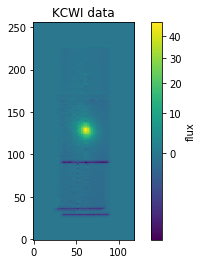

<Figure size 432x288 with 0 Axes>

In [35]:
'''
Step 1: visualization of the KCWI mosaic datacube
'''
# visualize the entire mosaic data
hdu = fits.open(kcwi_datacube)
datacube=hdu[0].data
visualization(hdu)
#plt.savefig(mos_dir + obj_name + '_mosaic.png')
plt.pause(1)
plt.clf()
hdu.close()

# Fit the central spectrum

In [36]:
hdu = fits.open(central_spectrum_file)
gal_lin = hdu[0].data
h1 = hdu[0].header
lamRange1 = h1['CRVAL1'] + np.array([0., h1['CDELT1']*(h1['NAXIS1'] - 1)])
print('CRVAL1 is', h1['CRVAL1'])
print('CDELT1 is', h1['CDELT1'])
print('NAXIS1 is', h1['NAXIS1'], gal_lin.shape[0])
FWHM_gal = FWHM

z = z # Initial estimate of the galaxy redshift
lamRange1 = lamRange1/(1+z) # Compute approximate restframe wavelength range
FWHM_gal = FWHM_gal/(1+z)   # Adjust resolution in Angstrom
galaxy, logLam1, velscale = ppxf_util.log_rebin(lamRange1, gal_lin)
lam = np.exp(logLam1)
print("velscale of the data is", velscale)
# de redshift

CRVAL1 is 3329.5
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is 33.25108193576141


In [37]:
# create a noise
if isinstance(noise,np.ndarray):
    noise = noise
else:
    noise = np.full_like(galaxy, noise) # Assume constant noise per
    # pixel here

In [38]:
# 11/19/23 - Truncating galaxy spectrum to wave_min and wave_max because it won't let it run while the galaxy spectrum extends to lower wavelengths than the templates
# Even though I am masking out those wavelengths anyway
print('Truncating galaxy and quasar spectrum to wave min and wave max')
# take the full lambda range so we can cut the other spectra accordingly
lam_full = lam.copy()
galaxy = galaxy[lam>wave_min] 
lam = lam[lam>wave_min]
galaxy = galaxy[lam<wave_max]
lam = lam[lam<wave_max]
#lamRange1 = [wave_min, wave_max]#
logLam1 = np.log(lam)
print('lamRange1 is', lamRange1) 

sps_name = 'emiles'

print('galaxy',galaxy.shape)
print('lam',lam.shape)

lam_range_temp = lamRange1[0]/1.2, lamRange1[1]*1.2

basename = f"spectra_{sps_name}_9.0.npz"
filename = path.join(ppxf_dir, 'sps_models', basename)
sps = sps_util.sps_lib(filename, velscale, FWHM_gal, wave_range=lam_range_temp)
templates= sps.templates
templates = templates.reshape(templates.shape[0], -1)

c = 299792.458
#dv = (np.mean(logLam2[:velscale_ratio]) - logLam1[0])*c  # km/s

# after de-redshift, the initial redshift is zero.
goodPixels = ppxf_util.determine_goodpixels(logLam1, lam_range_temp, 0)
#print(goodPixels)

ind_min = find_nearest(np.exp(logLam1), wave_min)
ind_max = find_nearest(np.exp(logLam1), wave_max)

mask=goodPixels[goodPixels<ind_max]
mask = mask[mask>ind_min]

boolen = ~((2956 < mask) & (mask < 2983))  # mask the Mg II
mask = mask[boolen]
boolen = ~((2983 < mask) & (mask < 3001))  # mask the Mg II
mask = mask[boolen]
# Here the actual fit starts. The best fit is plotted on the screen.
# Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
#
vel = c*np.log(1 + 0)   # eq.(8) of Cappellari (2017)
start = [vel, 250.]  # (km/s), starting guess for [V, sigma]
bounds = [[-500, 500],[50, 450]]
t = clock()

#noise = np.full_like(galaxy, 0.0047)

Truncating galaxy and quasar spectrum to wave min and wave max
lamRange1 is [2713.52893236 4838.22330888]
galaxy (2117,)
lam (2117,)


ValueError: Cannot load file containing pickled data when allow_pickle=False

In [ ]:
pp = ppxf(templates, galaxy, noise, velscale, start, plot=True,
          moments=2, goodpixels=mask,
          degree=28,#28,#28,#degree, m
          mdegree=3,#2,#mdegree,
          velscale_ratio=velscale_ratio,
          sky=background_source, 
         lam=lam,
          lam_temp=sps.lam_temp,
         #bounds=bounds
         )
#plt.xlim(wave_min*1e-4, wave_max*1e-4)
plt.pause(1)
    
print("Formal errors:")
print("     dV    dsigma   dh3      dh4")
print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

print('Elapsed time in pPXF: %.2f s' % (clock() - t))

nTemplates = pp.templates.shape[1]
global_temp = pp.templates @ pp.weights[:nTemplates]
global_temp_lam = pp.lam_temp
#global_temp = templates @ pp.weights[:nTemplates]
#global_temp_lam = sps.lam_temp

# Extensions for the nirspec_data fits file

In [6]:
#extensions	
#	1 sci
#	2 err
#	3 dq
#	4 wmap
#	5 hdrtab
#	6 asdf

In [7]:
with fits.open(nirspec_data) as hdul:
    print(hdul.info())
    sci_data = hdul[1].data
    sci_header = hdul[1].header
    err_data = hdul[2].data
    err_header = hdul[2].header
    dq_data = hdul[3].data
    dq_header = hdul[3].header
    wmap_data = hdul[4].data
    wmap_header = hdul[4].header
    hdrtab = hdul[5]
    


Filename: /data/raw_data/JWST/1794/Level3_g140m-f100lp_s3d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     366   ()      
  1  SCI           1 ImageHDU        92   (81, 79, 1447)   float32   
  2  ERR           1 ImageHDU        12   (81, 79, 1447)   float32   
  3  DQ            1 ImageHDU        12   (81, 79, 1447)   int32 (rescales to uint32)   
  4  WMAP          1 ImageHDU        10   (81, 79, 1447)   float32   
  5  HDRTAB        1 BinTableHDU    828   16R x 409C   [23A, 5A, 3A, 45A, 7A, 13A, 3A, 7A, 23A, 9A, 13A, 4A, L, D, D, D, D, 4A, 10A, 99A, 15A, 2A, D, 37A, D, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A, L, 24A, 16A, 2A, 26A, 20A, 27A, 10A, K, L, L, L, L, 23A, 23A, 5A, D, D, D, D, D, D, D, D, D, 8A, 7A, 4A, D, D, 6A, D, D, 5A, D, D, K, D, D, D, D, D, D, D, 4A, 3A, D, D, D, D, D, D, D, D, D, K, 5A, 7A, D, D, D, D, D, D, D, D, D, 7A, D, D, K, K, D, D, K, K, D, D, K, K, K, K, K, D, D, D, D, D, D, D, D, K, K, L

In [8]:
sci_header['CDELT3']*10**4

6.36000011581927

Text(0.5, 1.0, 'RXJ1131- NIRSpec data')

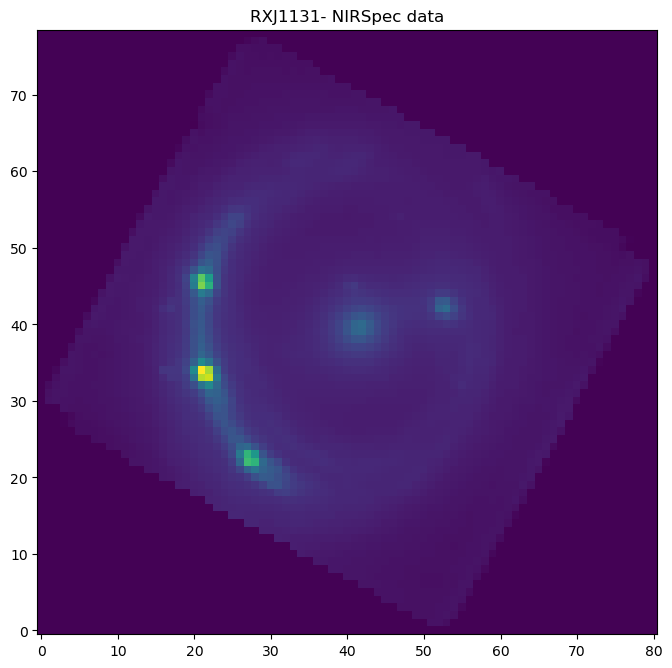

In [9]:
from astropy.visualization import simple_norm

'''
Step 1: visualization of the KCWI mosaic datacube
'''

norm = simple_norm(np.nansum(sci_data, axis=0), 'sqrt')
plt.figure(figsize=(8,8))
plt.imshow(np.nansum(sci_data, axis=0), origin="lower", norm=norm)
plt.title('RXJ1131- NIRSpec data')
#plt.colorbar(label='flux', shr)

In [10]:
# Units for the JWST data is Mjy / str

In [11]:
import pyregion
def getMaskInFitsFromDS9reg(input,nx,ny,hdu):
    r = pyregion.open(input)
    mask = r.get_mask(shape=(nx, ny),hdu=hdu)
    return mask



In [12]:
region = '/data/raw_data/JWST/1794/ds9_mask.reg'
mask_q = ~getMaskInFitsFromDS9reg(region,sci_data.shape[1],sci_data.shape[2],hdul[1])

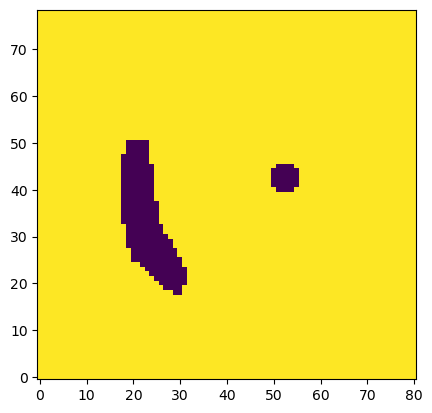

In [13]:
plt.imshow(mask_q, origin='lower')

In [14]:
sci_data_masked = sci_data*mask_q 
err_data_masked = err_data*mask_q 

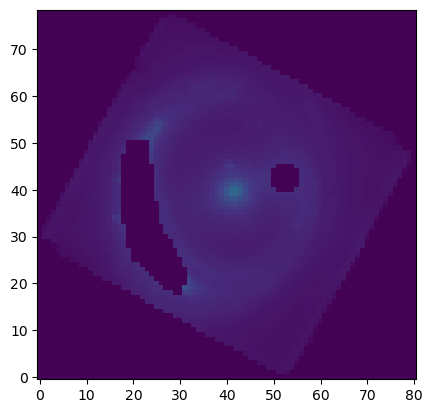

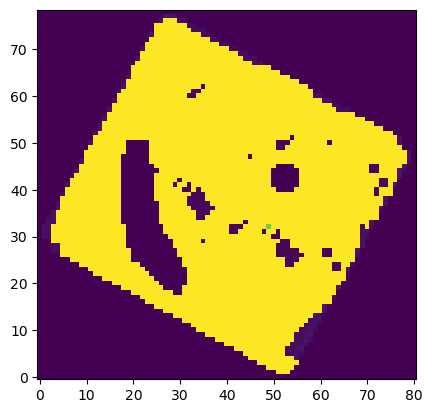

In [15]:
plt.imshow(np.nansum(sci_data_masked, axis=0), origin="lower", norm=norm)
plt.show()
plt.imshow(np.nansum(err_data_masked, axis=0), origin="lower", norm=norm)

In [16]:
# wavelengths in m
lower_wave = sci_header['WAVSTART'] # 9.7e-07
upper_wave = sci_header['WAVEND'] # 1.89e-06
wave_range = upper_wave - lower_wave
wave_delt = sci_header['CDELT3']
# exposure time
exp_time = sci_header['XPOSURE'] # s
# barycenter velocity
vbary = sci_header['VELOSYS'] # m/s
# FWHM at center wavelength
center_wavelength = (upper_wave + lower_wave)/2
R = 1000
FWHM = center_wavelength * 10**9 / R # 1.43 Angstroms

In [17]:
wavelengths = np.linspace(lower_wave, upper_wave, len(sci_data))

In [18]:
# what is my restframe wavelength range
lower_wave_rest = lower_wave / (1+zlens)
upper_wave_rest = upper_wave / (1+zlens)

In [19]:
lower_wave_rest*10**10

7490.347490347491

In [20]:
upper_wave_rest*10**10

14594.594594594595

### Data covers wavelengths 7490 A - 14594 A


In [21]:
#------------------------------------------------------------------------------
# Kinematics systematics initial choices

# stellar templates library
stellar_templates_library = 'all_dr2_fits_G789K012'

# aperture
aperture = 'R3'

# wavelength range in A
# I'm going to cut them smaller because the templates don't overlap
# data is 7490-14590 in restframe, go up to 10100
wave_min = 7600 #lower_wave_rest * 10**10 
wave_max = 14000#9500 #upper_wave * 10**9 

# degree of the additive Legendre polynomial in ppxf
degree = 12
mdegree= 3

#------------------------------------------------------------------------------
# Information specific to templates

FWHM_tem_xshooter = 0.776 # center wave 7760 / 10000 (R~10000) #0.43

## initial estimate of the noise
noise = 0.014

# velocity scale ratio
velscale_ratio = 2

#------------------------------------------------------------------------------
# variable settings in ppxf and utility functions

# cut the datacube at lens center, radius given here
#radius_in_pixels = 21

# target SN for voronoi binning
#vorbin_SN_targets = np.array([10, 15, 20])
SN = 10

# global template spectrum chi2 threshold
#global_template_spectrum_chi2_threshold = 1

#------------------------------------------------------------------------------

'''
Step 0: input the necessary information of the datacube
'''
#libary directory # chih-fan spelled wrong :)
#libary_dir_xshooter = f'{data_dir}xshooter_lib/{stellar_templates_library}/'
library_dir_xshooter_all = f'/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/xshooter_lib/all_dr2_fits/'


In [22]:
nirspec_scale

0.1


# Fit the global template.

In [23]:
from os import path
import ppxf.sps_util as sps_util

In [24]:
velscale_ratio=1

In [25]:
#wave_max = 14600

In [26]:
(wave_max - wave_min)/250 # degree of polynomial

25.6

In [461]:
mask_quasar=np.array([[8020, 8350, 8575], [8070, 8440, 8620]])

In [462]:
# data is 7490-14590 in restframe, go up to 10100
wave_min = 7600 #lower_wave_rest * 10**10 
wave_max = 10000 #upper_wave * 10**9 

In [463]:
ppxf_dir = path.dirname(path.realpath(ppxf_util.__file__))

file = central_spectrum_file
hdu = fits.open(file)

h1 = hdu[0].header
gal_lin = hdu[0].data
lamRange1 = h1['CRVAL1'] + np.array([0., h1['CDELT1']*(h1['NAXIS1'] - 1)])
print('CRVAL1 is', h1['CRVAL1'])
print('CDELT1 is', h1['CDELT1'])
print('NAXIS1 is', h1['NAXIS1'], gal_lin.shape[0])
# Change microns to angstroms
lamRange1 = lamRange1 * 10**4
FWHM_gal = FWHM

z = zlens # Initial estimate of the galaxy redshift
lamRange1 = lamRange1/(1+z) # Compute approximate restframe wavelength range
FWHM_gal = FWHM_gal/(1+z)   # Adjust resolution in Angstrom
galaxy, logLam1, velscale = ppxf_util.log_rebin(lamRange1, gal_lin)
lam = np.exp(logLam1)
# divide by wavelengths**2 to get correct units
galaxy /= lam**2
print('velscale is',velscale)

print('galaxy',galaxy.shape)
print('lam',lam.shape)

# Read a background_source spectrum and define the wavelength range
file_q = quasar_spectrum_file
hdu_q = fits.open(file_q) # open the fits file (if it's a fits file)
h1_q = hdu_q[0].header # take header
lamRange1_q = h1_q['CRVAL1'] + np.array( # wavelength range
    [0., h1_q['CDELT1'] * (h1_q['NAXIS1'] - 1)])
# Change microns to angstroms
lamRange1_q = lamRange1_q * 10**4
background_source_lin = hdu_q[0].data 

lamRange1_q = lamRange1_q/(1+z) # Compute approximate restframe wavelength 
background_source, logLam1_q, velscale_q = ppxf_util.log_rebin(lamRange1_q, background_source_lin)
background_source /= lam**2
background_source = background_source/np.median(background_source)  # Normalize spectrum to avoid numerical# Read a background_source spectrum and define the wavelength range

# 11/19/23 - Truncating galaxy spectrum to wave_min and wave_max because it won't let it run while the galaxy spectrum extends to lower wavelengths than the templates
# Even though I am masking out those wavelengths anyway
print('Truncating galaxy and quasar spectrum to wave min and wave max')
# take the full lambda range so we can cut the other spectra accordingly
lam_full = lam.copy()
background_source_full = background_source.copy()
galaxy = galaxy[lam>wave_min] 
background_source = background_source[lam>wave_min] 
lam = lam[lam>wave_min]
galaxy = galaxy[lam<wave_max]
background_source = background_source[lam<wave_max]#
lam = lam[lam<wave_max]
#lamRange1 = [wave_min, wave_max]#
logLam1 = np.log(lam)
print('lamRange1 is', lamRange1) 

sps_name = 'emiles'

print('galaxy',galaxy.shape)
print('lam',lam.shape)

lam_range_temp = [1000, 18000]#lamRange1[0]/1.2, lamRange1[1]*1.2]

basename = f"spectra_{sps_name}_9.0.npz"
filename = path.join(ppxf_dir, 'sps_models', basename)
sps = sps_util.sps_lib(filename, velscale, FWHM_gal, wave_range=lam_range_temp)
templates= sps.templates
templates = templates.reshape(templates.shape[0], -1)

c = 299792.458
#dv = (np.mean(logLam2[:velscale_ratio]) - logLam1[0])*c  # km/s

# after de-redshift, the initial redshift is zero.
goodPixels = ppxf_util.determine_goodpixels(logLam1, lam_range_temp, 0)
#print(goodPixels)

ind_min = find_nearest(np.exp(logLam1), wave_min)
ind_max = find_nearest(np.exp(logLam1), wave_max)

mask=goodPixels[goodPixels<ind_max]
mask = mask[mask>ind_min]
if mask_quasar is not None:
    print('masking quasar between ', mask_quasar)
    for i in range(mask_quasar.shape[1]):
        # mask_quasar should be a list of two wavelengths
        quasar_ind_min = find_nearest(np.exp(logLam1), mask_quasar[0,i])
        quasar_ind_max = find_nearest(np.exp(logLam1), mask_quasar[1,i])
        boolen = ~((quasar_ind_min < mask) & (mask < quasar_ind_max))  # mask quasar
        mask = mask[boolen]
#boolen = ~((2956 < mask) & (mask < 2983))  # mask the Mg II
#mask = mask[boolen]
#boolen = ~((2983 < mask) & (mask < 3001))  # mask the Mg II
#mask = mask[boolen]
# Here the actual fit starts. The best fit is plotted on the screen.
# Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
#
vel = c*np.log(1 + 0)   # eq.(8) of Cappellari (2017)
start = [vel, 250.]  # (km/s), starting guess for [V, sigma]
bounds = [[-500, 500],[50, 450]]
t = clock()

noise = np.full_like(galaxy, 0.0047)



CRVAL1 is 0.97031802861602
CDELT1 is 0.000636000011581927
NAXIS1 is 1447 1447
velscale is 138.229913538939
galaxy (1447,)
lam (1447,)
Truncating galaxy and quasar spectrum to wave min and wave max
lamRange1 is [ 7492.80330978 14594.39417269]
galaxy (595,)
lam (595,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]


 Best Fit:       Vel     sigma
 comp.  0:       201       322
chi2/DOF: 7.565e-11; DOF: 544; degree = 28; mdegree = 3
method = capfit; Jac calls: 4; Func calls: 26; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/151


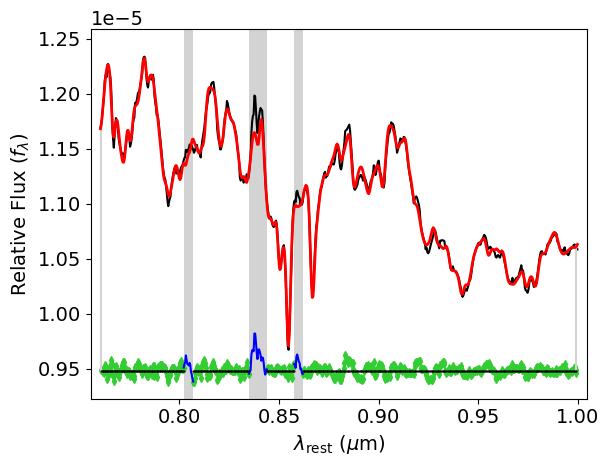

Formal errors:
     dV    dsigma   dh3      dh4
       5     6.4
Elapsed time in pPXF: 1.93 s


In [464]:
pp = ppxf(templates, galaxy, noise, velscale, start, plot=True,
          moments=2, goodpixels=mask,
          degree=28,#28,#28,#degree, m
          mdegree=3,#2,#mdegree,
          velscale_ratio=velscale_ratio,
          sky=background_source, 
         lam=lam,
          lam_temp=sps.lam_temp,
         #bounds=bounds
         )
#plt.xlim(wave_min*1e-4, wave_max*1e-4)
plt.pause(1)
    
print("Formal errors:")
print("     dV    dsigma   dh3      dh4")
print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

print('Elapsed time in pPXF: %.2f s' % (clock() - t))

nTemplates = pp.templates.shape[1]
global_temp = pp.templates @ pp.weights[:nTemplates]
global_temp_lam = pp.lam_temp
#global_temp = templates @ pp.weights[:nTemplates]
#global_temp_lam = sps.lam_temp

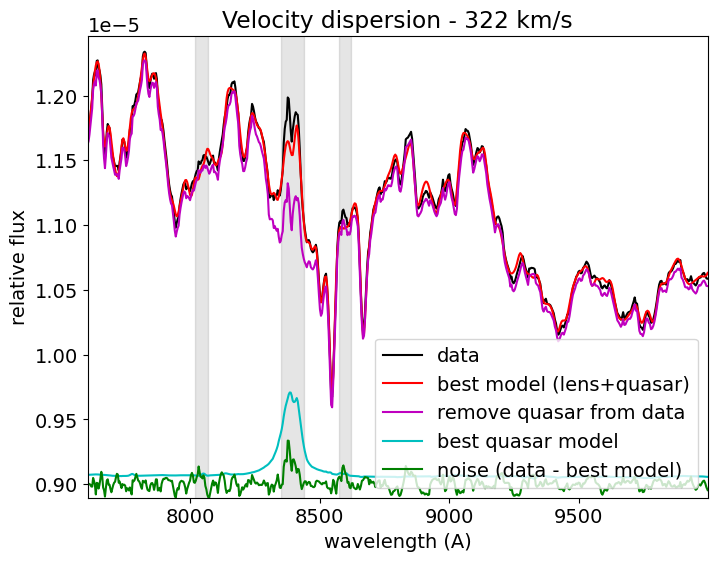

In [465]:
best_sky = background_source * pp.weights[-1]

gal_lin = pp.galaxy#spectrum_perpixel

log_axis_sky = np.exp(logLam1)
lin_axis_sky = lam#np.linspace(lamRange1[0], lamRange1[1], gal_lin.size)

sky_lin = de_log_rebin(log_axis_sky, best_sky, lin_axis_sky)
best_lin = de_log_rebin(log_axis_sky, pp.bestfit, lin_axis_sky)
gal_lin = de_log_rebin(log_axis_sky, gal_lin, lin_axis_sky)

more_noise = gal_lin - best_lin

plt.figure(figsize=(8,6))
plt.plot(lin_axis_sky, gal_lin, 'k-', label='data')
plt.plot(lin_axis_sky, best_lin, 'r-', label='best model ('
                                             'lens+quasar)')
plt.plot(lin_axis_sky, gal_lin - sky_lin, 'm-',
         label='remove quasar from data')
plt.plot(lin_axis_sky, sky_lin + np.full_like(sky_lin, 0.9e-5), 'c-',label='best quasar model')
plt.plot(lin_axis_sky, more_noise + np.full_like(sky_lin, 0.9e-5), 'g-',
         label='noise (data - best model)')
if mask_quasar is not None:
    for i in range(mask_quasar.shape[1]):
        plt.fill_between(mask_quasar[:,i], [0,0], [1,1], color='k', alpha=0.1)
plt.legend(loc='lower right')
plt.ylim(np.min(more_noise + np.full_like(sky_lin, 0.9e-5)), np.max(gal_lin)*1.01)
plt.xlim(lin_axis_sky.min(), lin_axis_sky.max())
plt.xlabel('wavelength (A)')
plt.ylabel('relative flux')
plt.title(f'Velocity dispersion - {int(pp.sol[1])} km/s')
plt.show()
plt.pause(1)

# Crop data to 2 arcsec and wavelength range desired

In [466]:
restframe_range = (lam_full > wave_min) & (lam_full < wave_max)


In [467]:
lens_center_x = 43
lens_center_y = 41
r = 10

In [468]:
sci_data_crop = sci_data_masked.copy()[:, lens_center_y - r-1:lens_center_y + r, lens_center_x- r -1:lens_center_x + r]
err_data_crop = err_data_masked.copy()[:, lens_center_y - r-1:lens_center_y + r, lens_center_x- r -1:lens_center_x + r]

In [469]:
sum_cube = np.nansum(sci_data_crop, axis=0)

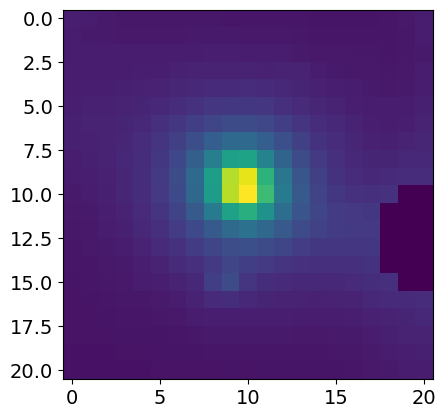

In [470]:
plt.imshow(sum_cube)

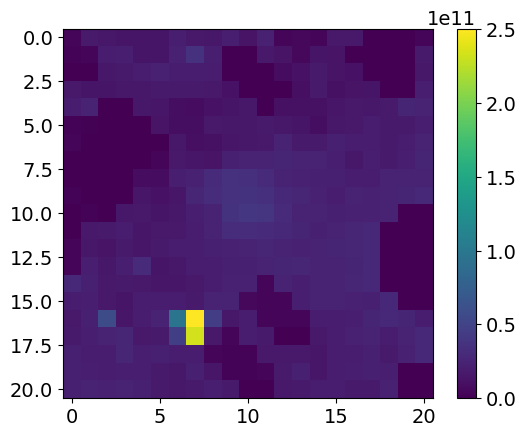

In [471]:
p = plt.imshow(np.nansum(err_data_crop, axis=0))
plt.colorbar(p)
#plt.scatter(50, 10)

In [472]:
# weird spaxels

In [473]:
any(np.ravel(np.nansum(err_data_crop, axis=0)) > 2e11)

True

In [474]:
bad_spax_err = np.argwhere(np.nansum(err_data_crop, axis=0) > 9e10)

In [475]:
err_data_crop[:,bad_spax_err[:,0],bad_spax_err[:,1]]='nan'
#sci_data_crop[:,bad_spax_err[:,0],bad_spax_err[:,1]]='nan'

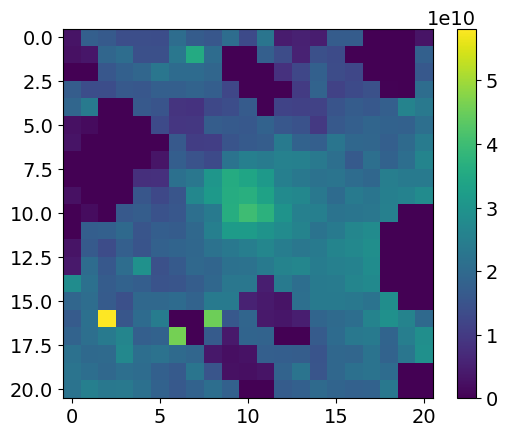

In [476]:
p = plt.imshow(np.nansum(err_data_crop, axis=0))
plt.colorbar(p)
#plt.scatter(50, 10)

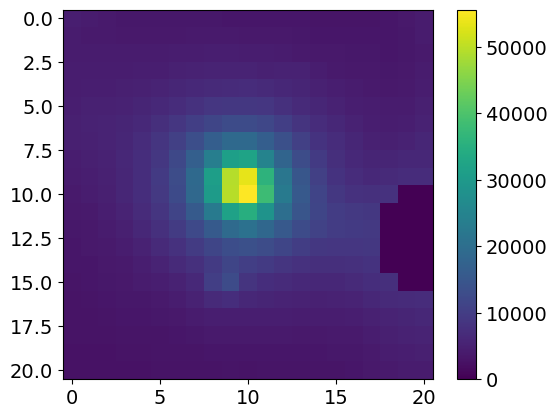

In [477]:
p = plt.imshow(np.nansum(sci_data_crop, axis=0))
plt.colorbar(p)

In [478]:
plt.rcParams.update({'font.size': 14})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


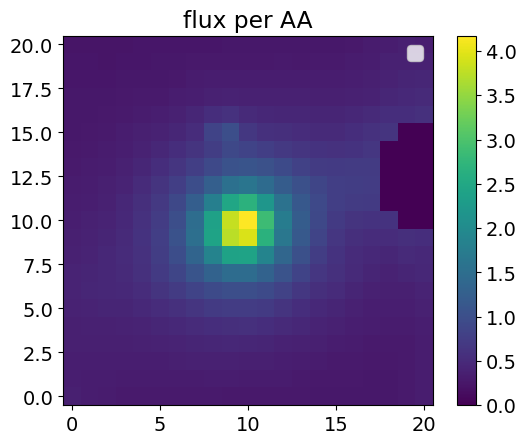

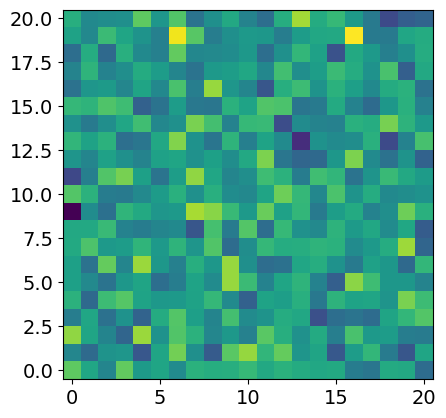

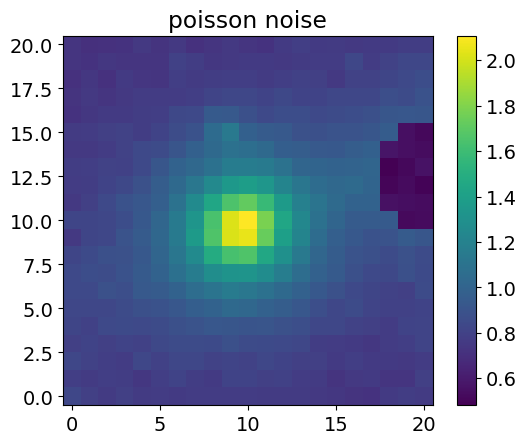

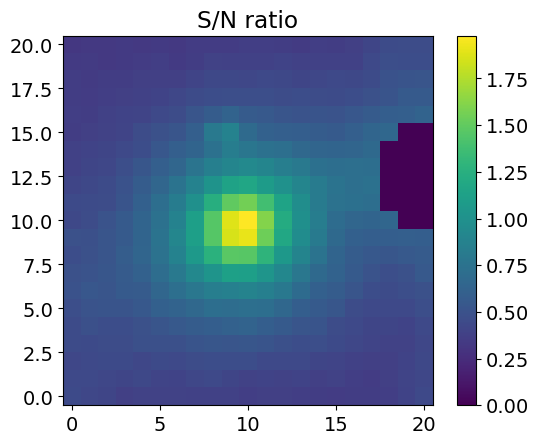

In [479]:
'''
Step 4: create the S/N map
'''

#estimate the noise from the blank sky
noise_from_blank = sci_data[:,5:10,50:55]
std = np.nanstd(noise_from_blank)
mean = np.nanmean(noise_from_blank)
s = np.random.normal(mean, std, sci_data_crop.flatten().shape[0])
noise_cube = s.reshape(sci_data_crop.shape)

## in the following, I use the noise spectrum and datacube with no quasar
# light produced in the previous steps to estimate the S/N per AA. Since KCWI
#  is  0.5AA/pixel, I convert the value to S/N per AA. Note that I use only the
# region of Ca triplet to estimate the S/N ratio (i.e. 8000-9000AA).
lin_axis_sky = lam_full[restframe_range]#np.linspace(lamRange1[0], lamRange1[1], sci_data_crop.shape[0])
ind_min_SN = find_nearest(lin_axis_sky, 8000)
ind_max_SN = find_nearest(lin_axis_sky, 9000)

plt.figure()
SN_per_AA, flux_per_AA, sigma_poisson = SN_Ca(ind_min_SN,ind_max_SN,
                                           sci_data_crop,
                               noise_cube,# 
                               #err_data_crop, 
                               exp_time)

#fits.writeto(kin_dir + obj_name + '_SN_per_AA.fits', SN_per_AA, overwrite=True)
#plt.savefig(kin_dir + obj_name + '_SN_per_AA.png')


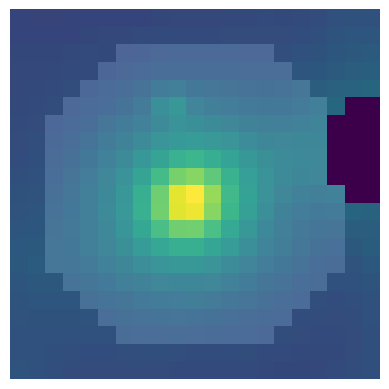

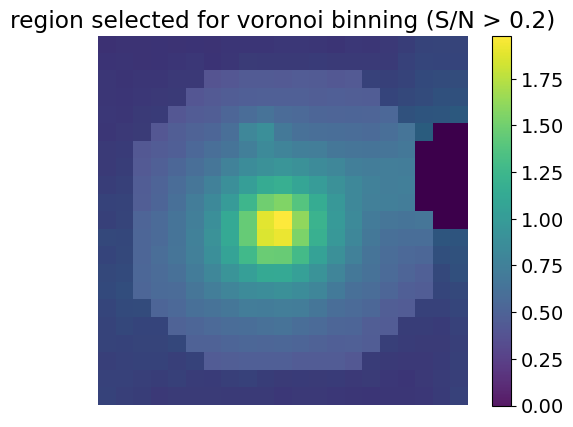

Bin-accretion...
1  /  116
2  /  116
3  /  116
4  /  116
5  /  116
6  /  116
7  /  116
8  /  116
9  /  116
10  /  116
11  /  116
12  /  116
13  /  116
14  /  116
15  /  116
16  /  116
17  /  116
18  /  116
19  /  116
20  /  116
21  /  116
22  /  116
23  /  116
24  /  116
25  /  116
26  /  116
27  /  116
28  /  116
29  /  116
30  /  116
31  /  116
32  /  116
33  /  116
34  /  116
35  /  116
36  /  116
37  /  116
38  /  116
39  /  116
40  /  116
41  /  116
42  /  116
43  /  116
44  /  116
45  /  116
46  /  116
47  /  116
48  /  116
49  /  116
50  /  116
51  /  116
52  /  116
53  /  116
54  /  116
55  /  116
56  /  116
57  /  116
58  /  116
59  /  116
60  /  116
61  /  116
62  /  116
63  /  116
64  /  116
65  /  116
66  /  116
67  /  116
68  /  116
69  /  116
70  /  116
71  /  116
72  /  116
73  /  116
74  /  116
75  /  116
76  /  116
77  /  116
78  /  116
79  /  116
80  /  116
81  /  116
82  /  116
83  /  116
84  /  116
85  /  116
86  /  116
87  /  116
88  /  116
89  /  116
90  /  116
91

<Figure size 640x480 with 0 Axes>

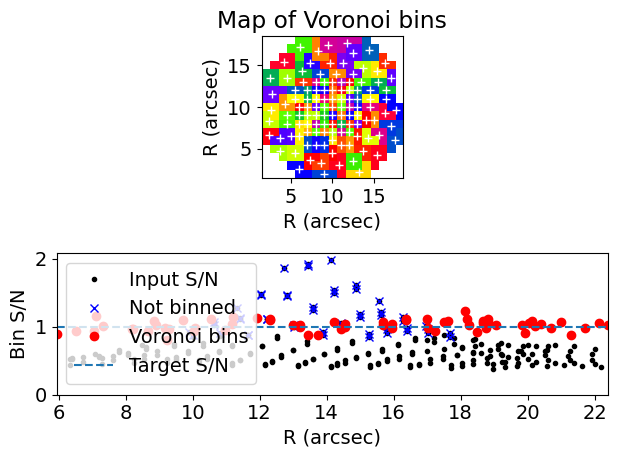

<Figure size 640x480 with 0 Axes>

In [480]:
SN_y_center, SN_x_center = np.unravel_index(np.nanargmax(SN_per_AA), SN_per_AA.shape)
max_radius = r-1
target_SN = 0.2
radius_in_pixels=r
SN = 1.0

origin_imaging_data_perAA = np.mean(sci_data_crop[ind_min_SN:ind_max_SN,:,:],
                                 axis=0)*2
#############################################################################################################
#### Voronoi binning


target_dir = data_dir

# select the region for binning
plt.figure()
select_region(target_dir, origin_imaging_data_perAA, SN_per_AA, # saves to kinematic directory
              SN_x_center,SN_y_center, radius_in_pixels,
              max_radius,
              target_SN, obj_name)
#plt.savefig(target_dir + obj_name + '_selected_region.png')
plt.pause(1)
plt.clf()

## conduct the voronoi binning (produce the map for mapping pixels to bins)
plt.figure()
voronoi_binning(SN, target_dir, obj_name)
plt.tight_layout()
#plt.savefig(target_dir + obj_name + '_voronoi_binning.png')
#plt.savefig(target_dir + obj_name + '_voronoi_binning.pdf') 
plt.pause(1)
plt.clf()



Number of bins = 116


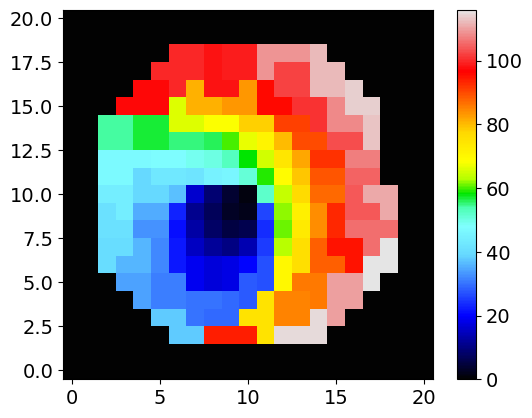

In [481]:
## get voronoi_binning_data based on the map
output=np.loadtxt(data_dir +'voronoi_2d_binning_' + obj_name + '_output.txt')

b=np.zeros((int(np.max(output.T[2]))+1,sci_data_crop.shape[0])) #construct the binning
#  data
check = np.zeros(sci_data_crop[0, :, :].shape)
for i in range(output.shape[0]):
    wx = int(output[i][0])
    wy = int(output[i][1])
    num = int(output[i][2])
    b[num]=b[num]+sci_data_crop[:,wy,wx]
    check[wy, wx] = num+1

fits.writeto(data_dir +'voronoi_binning_' + obj_name + '_data.fits', b, overwrite=True)
print("Number of bins =", b.shape[0])
plt.imshow(check, origin="lower", cmap='sauron')
plt.colorbar()
#for (j, i), label in np.ndenumerate(check):
#    plt.text(i, j, label, ha='center', va='center')
plt.show()


In [482]:
global_temp.shape

(636,)

In [483]:
lam.max()

9999.001101321255

In [484]:
lamRange1

array([ 7492.80330978, 14594.39417269])

In [485]:
global_temp_lam.max()

10094.961944826033

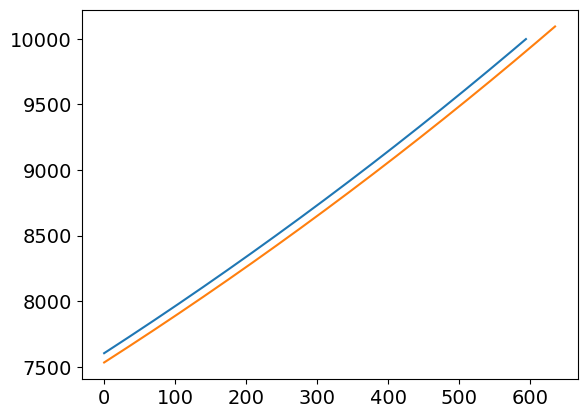

In [486]:
plt.plot(lam)
plt.plot(global_temp_lam)

_________

# Try a 3x3 box analysis instead.
See https://mail.google.com/mail/u/0/?tab=rm&ogbl#search/david+law/FMfcgzGwHxqJnlDxbHKKxPMwlHksGkMV

One word of warning though- both JWST IFUs are spatially undersampled, and this can cause problems when resampling the native detector scale images to reguarly-gridded cubes.  In brief, spectra of individual spaxels can show variable-periodicity amplitude modulations (particularly near unresolved sources) related to the pixel-boundary crossing of the traces on the detector (see Law+23 for details: https://ui.adsabs.harvard.edu/abs/2023AJ....166...45L/abstract).  I can see a little bit of that in your data cubes if I plot the spectra of individual spaxels.  However, this effect goes away very quickly using larger extraction apertures.  If you want to do a classical spaxel-by-spaxel analysis of the field, I'd suggest instead a moving 3x3 box instead (i.e., sum spectra in a 3x3 box for analysis, move one pixel over and draw another 3x3 box, repeat).  That should give you pretty decent results without smearing things too much given the strong covariance between adjacent spaxels anyway.  The Law+ paper measured this covariance for the MIRI MRS (in a manner that will be familiar to Michele from MaNGA days)- I haven't estimated it for the NIRSpec IFU but would imagine it's broadly similar.


In [487]:
# Use a 3x3 kernel of 1s

kernel = np.ones((3,3))
kernel

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [488]:
from scipy.signal import convolve2d as conv

In [489]:
conv_data = np.zeros_like(sci_data)

for i in range(sci_data.shape[0]):
    conv_data_wave = conv(sci_data[i], kernel)
    conv_data[i] = conv_data_wave[1:-1, 1:-1]

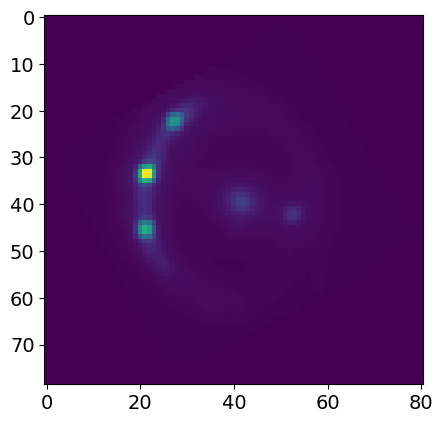

In [490]:
plt.imshow(np.nansum(conv_data,axis=0))

In [491]:
mask_q = ~getMaskInFitsFromDS9reg(region,sci_data.shape[1],sci_data.shape[2],hdul[1])
sci_data_conv_masked = conv_data*mask_q

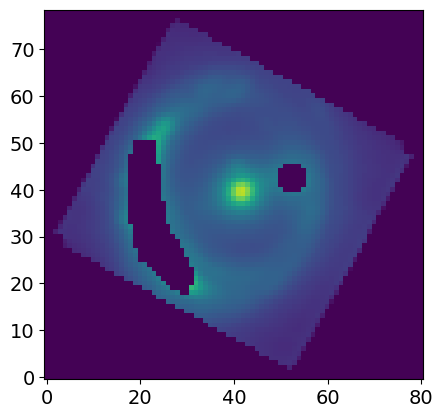

In [492]:
plt.imshow(np.nansum(sci_data_conv_masked, axis=0), origin="lower", norm=norm)
plt.show()
#plt.imshow(np.nansum(err_data_masked, axis=0), origin="lower", norm=norm)

In [493]:
sci_data_crop_conv = sci_data_conv_masked.copy()[:, lens_center_y - r-1:lens_center_y + r, lens_center_x- r -1:lens_center_x + r]
#err_data_crop_conv = err_data_conv_masked.copy()[:, lens_center_y - r-1:lens_center_y + r, lens_center_x- r -1:lens_center_x + r]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


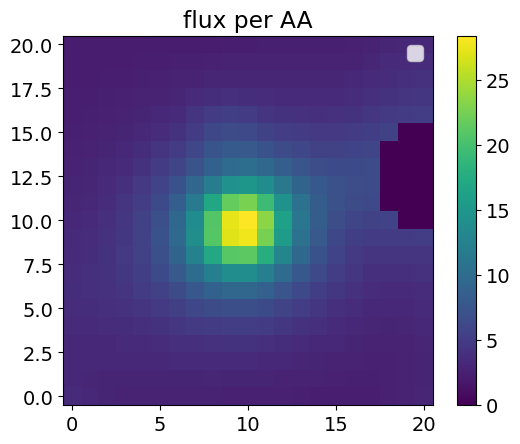

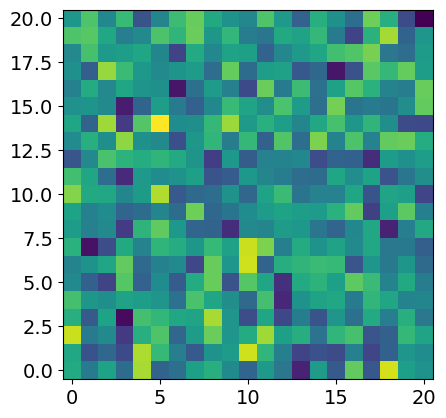

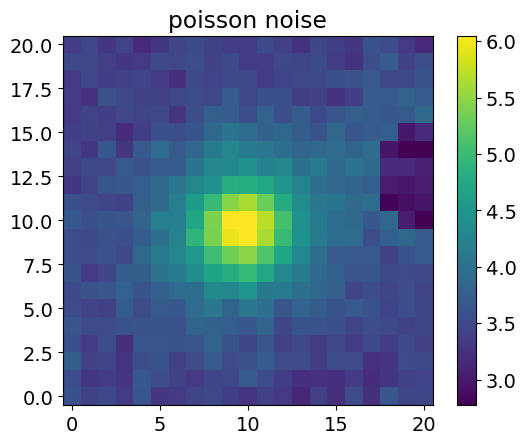

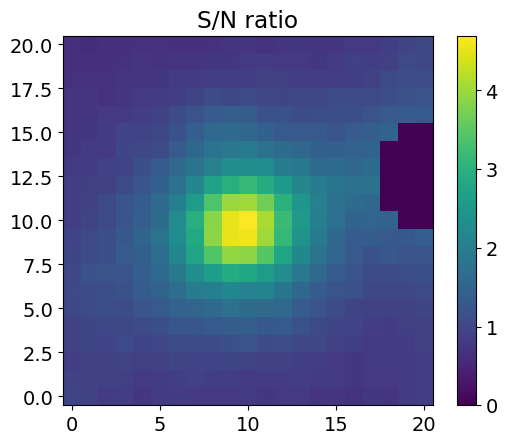

In [494]:
'''
Step 4: create the S/N map
'''

#estimate the noise from the blank sky
noise_from_blank = sci_data_conv_masked[:,5:10,50:55]
std = np.nanstd(noise_from_blank)
mean = np.nanmean(noise_from_blank)
s = np.random.normal(mean, std, sci_data_crop_conv.flatten().shape[0])
noise_cube = s.reshape(sci_data_crop_conv.shape)

## in the following, I use the noise spectrum and datacube with no quasar
# light produced in the previous steps to estimate the S/N per AA. Since KCWI
#  is  0.5AA/pixel, I convert the value to S/N per AA. Note that I use only the
# region of Ca triplet to estimate the S/N ratio (i.e. 8000-9000AA).
lin_axis_sky = lam_full[restframe_range]#np.linspace(lamRange1[0], lamRange1[1], sci_data_crop.shape[0])
ind_min_SN = find_nearest(lin_axis_sky, 8000)
ind_max_SN = find_nearest(lin_axis_sky, 9000)

plt.figure()
SN_per_AA, flux_per_AA, sigma_poisson = SN_Ca(ind_min_SN,ind_max_SN,
                                           sci_data_crop_conv,
                               noise_cube,# 
                               #err_data_crop, 
                               exp_time)

#fits.writeto(kin_dir + obj_name + '_SN_per_AA.fits', SN_per_AA, overwrite=True)
#plt.savefig(kin_dir + obj_name + '_SN_per_AA.png')


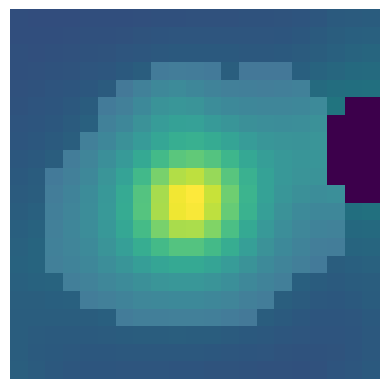

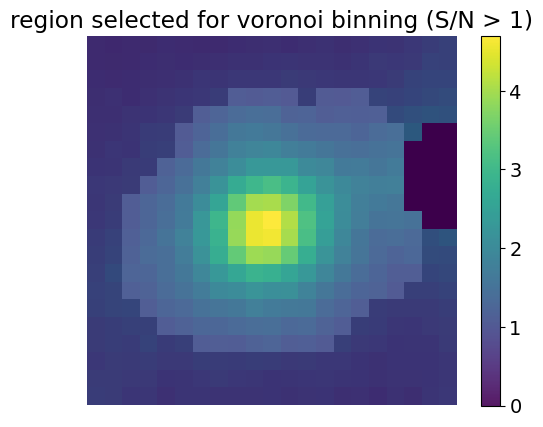

Bin-accretion...
1  /  76
2  /  76
3  /  76
4  /  76
5  /  76
6  /  76
7  /  76
8  /  76
9  /  76
10  /  76
11  /  76
12  /  76
13  /  76
14  /  76
15  /  76
16  /  76
17  /  76
18  /  76
19  /  76
20  /  76
21  /  76
22  /  76
23  /  76
24  /  76
25  /  76
26  /  76
27  /  76
28  /  76
29  /  76
30  /  76
31  /  76
32  /  76
33  /  76
34  /  76
35  /  76
36  /  76
37  /  76
38  /  76
39  /  76
40  /  76
41  /  76
42  /  76
43  /  76
44  /  76
45  /  76
46  /  76
47  /  76
48  /  76
49  /  76
50  /  76
51  /  76
52  /  76
53  /  76
54  /  76
55  /  76
56  /  76
57  /  76
58  /  76
59  /  76
60  /  76
61  /  76
62  /  76
63  /  76
64  /  76
65  /  76
66  /  76
67  /  76
68  /  76
69  /  76
70  /  76
71  /  76
72  /  76
73  /  76
74  /  76
75  /  76
76  /  76
77  /  76
78  /  76
79  /  76
80  /  76
77  initial bins.
Reassign bad bins...
74  good bins.
Modified Lloyd algorithm...
Iter:    1  Diff: 1.172
Iter:    2  Diff: 0.7159
Iter:    3  Diff: 0
2  iterations.
Unbinned pixels:  29  /  2

<Figure size 640x480 with 0 Axes>

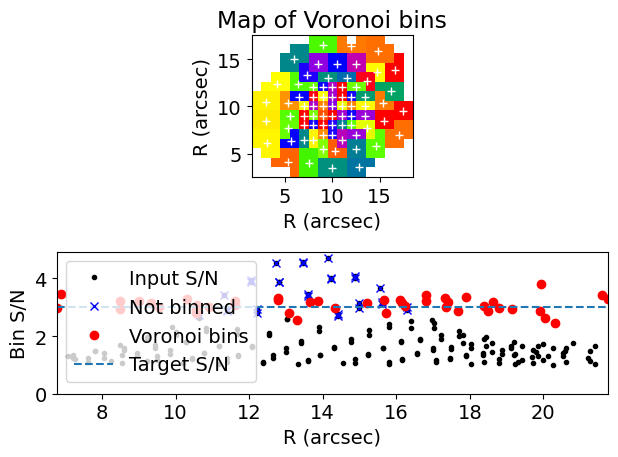

<Figure size 640x480 with 0 Axes>

In [495]:
SN_y_center, SN_x_center = np.unravel_index(np.nanargmax(SN_per_AA), SN_per_AA.shape)
max_radius = r-1
target_SN = 1
radius_in_pixels=r
SN = 3

origin_imaging_data_perAA = np.mean(sci_data_crop_conv[ind_min_SN:ind_max_SN,:,:],
                                 axis=0)*2
#############################################################################################################
#### Voronoi binning


target_dir = data_dir

# select the region for binning
plt.figure()
select_region(target_dir, origin_imaging_data_perAA, SN_per_AA, # saves to kinematic directory
              SN_x_center,SN_y_center, radius_in_pixels,
              max_radius,
              target_SN, obj_name)
#plt.savefig(target_dir + obj_name + '_selected_region.png')
plt.pause(1)
plt.clf()

## conduct the voronoi binning (produce the map for mapping pixels to bins)
plt.figure()
voronoi_binning(SN, target_dir, obj_name)
plt.tight_layout()
#plt.savefig(target_dir + obj_name + '_voronoi_binning.png')
#plt.savefig(target_dir + obj_name + '_voronoi_binning.pdf') 
plt.pause(1)
plt.clf()



Number of bins = 74


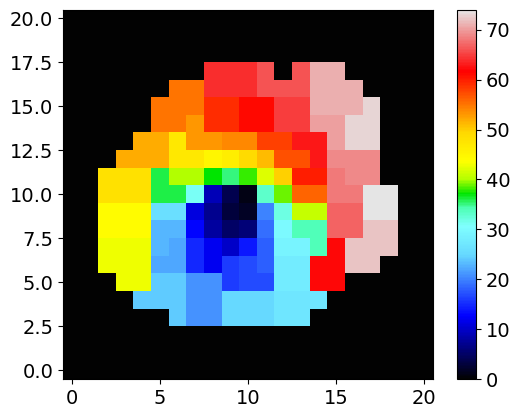

In [496]:
## get voronoi_binning_data based on the map
output=np.loadtxt(data_dir +'voronoi_2d_binning_' + obj_name + '_output.txt')

b=np.zeros((int(np.max(output.T[2]))+1,sci_data_crop_conv.shape[0])) #construct the binning
#  data
check = np.zeros(sci_data_crop_conv[0, :, :].shape)
for i in range(output.shape[0]):
    wx = int(output[i][0])
    wy = int(output[i][1])
    num = int(output[i][2])
    b[num]=b[num]+sci_data_crop_conv[:,wy,wx]
    check[wy, wx] = num+1

fits.writeto(data_dir +'voronoi_binning_' + obj_name + '_data.fits', b, overwrite=True)
print("Number of bins =", b.shape[0])
plt.imshow(check, origin="lower", cmap='sauron')
plt.colorbar()
#for (j, i), label in np.ndenumerate(check):
#    plt.text(i, j, label, ha='center', va='center')
plt.show()



###########################################################
bin number 0
velscale is  138.229913538939
galaxy (595,)
lam (595,)
global_etmp (636,)
glob lam (636,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]
 Best Fit:       Vel     sigma
 comp.  0:       219       348
chi2/DOF: 6.621e-12; DOF: 537; degree = 30; mdegree = 10
method = capfit; Jac calls: 4; Func calls: 55; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
     0.222   1.1e-08


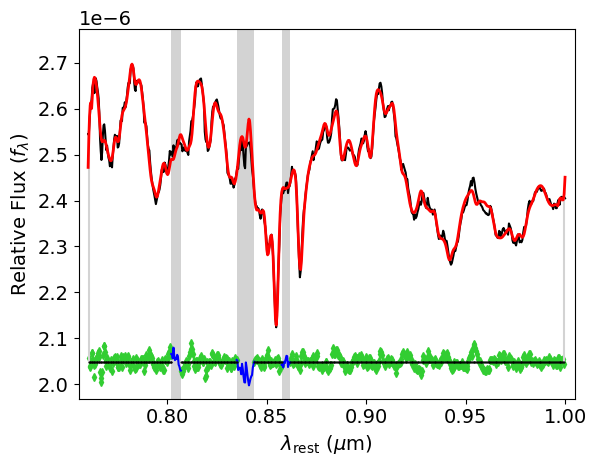

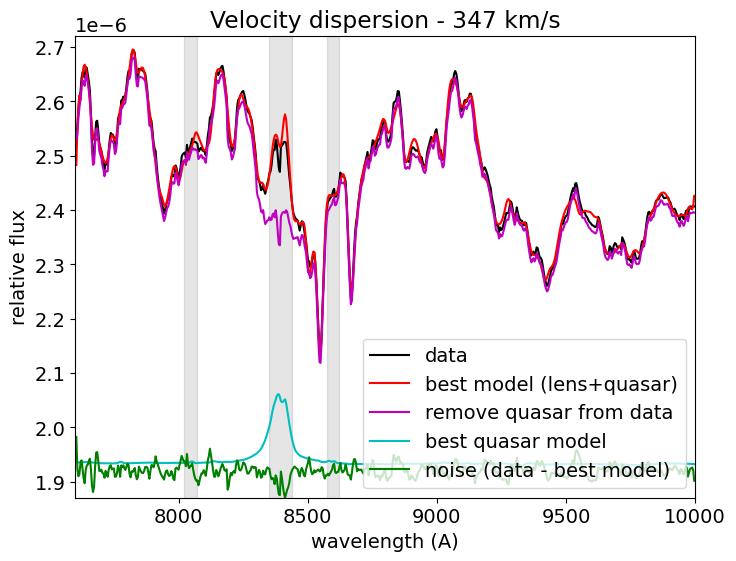

Formal errors:
     dV    dsigma   dh3      dh4
     6.9     8.5
Elapsed time in pPXF: 419.17 s

###########################################################
bin number 1
velscale is  138.229913538939
galaxy (595,)
lam (595,)
global_etmp (636,)
glob lam (636,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]
 Best Fit:       Vel     sigma
 comp.  0:       223       363
chi2/DOF: 6.406e-12; DOF: 537; degree = 30; mdegree = 10
method = capfit; Jac calls: 4; Func calls: 55; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
     0.221  9.98e-09
Formal errors:
     dV    dsigma   dh3      dh4
     7.3       9
Elapsed time in pPXF: 420.37 s

###########################################################
bin number 2
velscale is  138.229913538939
galaxy (595,)
lam (595,)
global_etmp (636,)
glob lam (636,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]
 Best Fit:       Vel     sigma
 comp.  0:       224       361
chi2/DOF: 6.352e-12; DOF

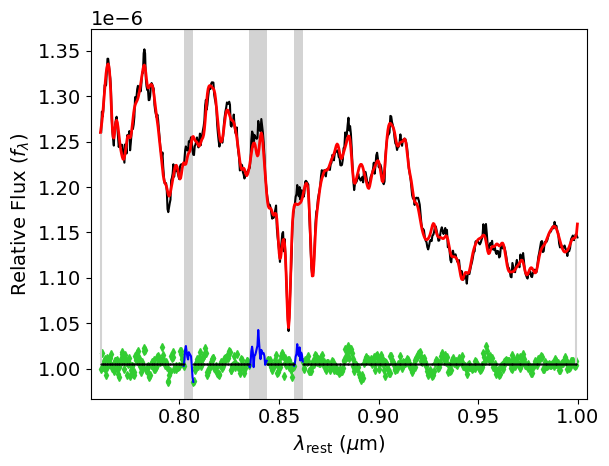

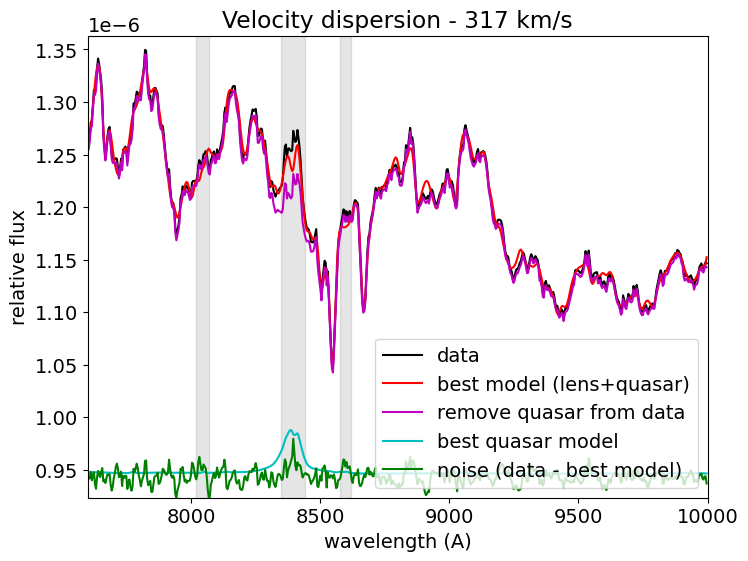

Formal errors:
     dV    dsigma   dh3      dh4
       8      10
Elapsed time in pPXF: 433.68 s

###########################################################
bin number 11
velscale is  138.229913538939
galaxy (595,)
lam (595,)
global_etmp (636,)
glob lam (636,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]
 Best Fit:       Vel     sigma
 comp.  0:       176       309
chi2/DOF: 5.095e-12; DOF: 537; degree = 30; mdegree = 10
method = capfit; Jac calls: 6; Func calls: 82; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
     0.141  1.38e-08
Formal errors:
     dV    dsigma   dh3      dh4
     8.6      11
Elapsed time in pPXF: 434.99 s

###########################################################
bin number 12
velscale is  138.229913538939
galaxy (595,)
lam (595,)
global_etmp (636,)
glob lam (636,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]
 Best Fit:       Vel     sigma
 comp.  0:       205       305
chi2/DOF: 1.756e-12; D

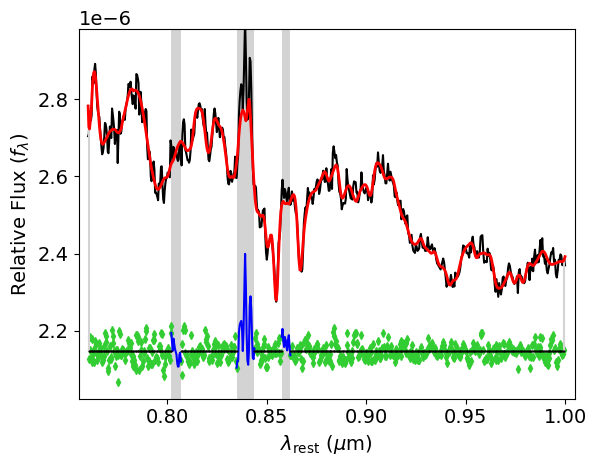

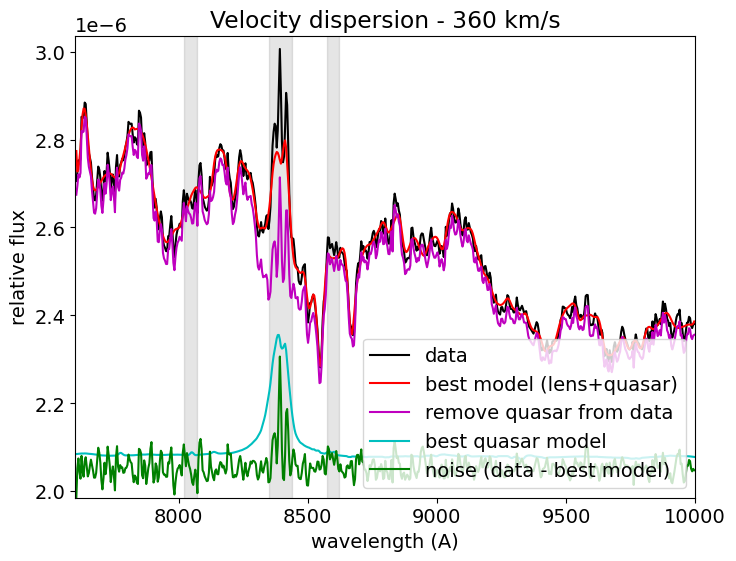

Formal errors:
     dV    dsigma   dh3      dh4
      16      19
Elapsed time in pPXF: 448.51 s

###########################################################
bin number 21
velscale is  138.229913538939
galaxy (595,)
lam (595,)
global_etmp (636,)
glob lam (636,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]
 Best Fit:       Vel     sigma
 comp.  0:       183       307
chi2/DOF: 7.296e-12; DOF: 537; degree = 30; mdegree = 10
method = capfit; Jac calls: 24; Func calls: 322; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
     0.131  2.38e-08
Formal errors:
     dV    dsigma   dh3      dh4
      11      14
Elapsed time in pPXF: 450.68 s

###########################################################
bin number 22
velscale is  138.229913538939
galaxy (595,)
lam (595,)
global_etmp (636,)
glob lam (636,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]
 Best Fit:       Vel     sigma
 comp.  0:       197       290
chi2/DOF: 8.245e-12;

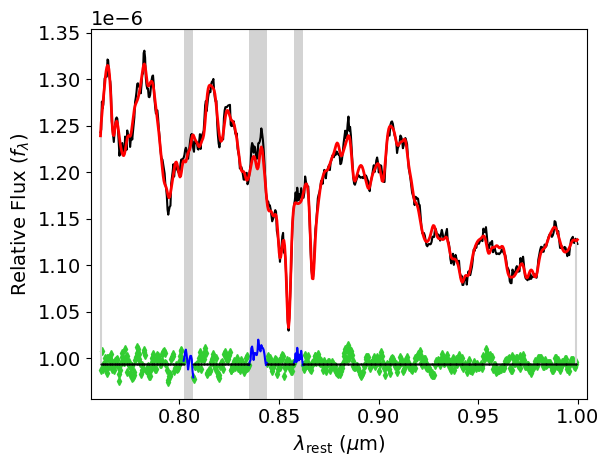

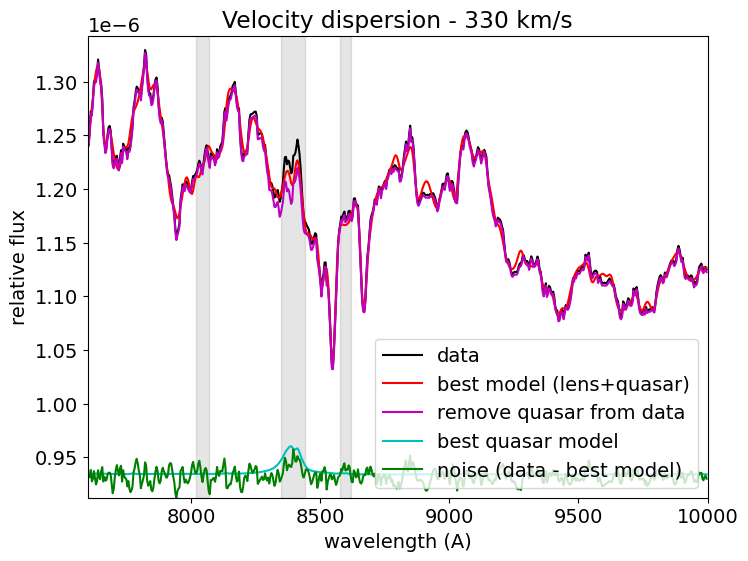

Formal errors:
     dV    dsigma   dh3      dh4
     8.2      10
Elapsed time in pPXF: 464.27 s

###########################################################
bin number 31
velscale is  138.229913538939
galaxy (595,)
lam (595,)
global_etmp (636,)
glob lam (636,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]
 Best Fit:       Vel     sigma
 comp.  0:       198       338
chi2/DOF: 2.983e-12; DOF: 537; degree = 30; mdegree = 10
method = capfit; Jac calls: 5; Func calls: 68; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
     0.121  7.45e-09
Formal errors:
     dV    dsigma   dh3      dh4
     8.4      11
Elapsed time in pPXF: 465.55 s

###########################################################
bin number 32
velscale is  138.229913538939
galaxy (595,)
lam (595,)
global_etmp (636,)
glob lam (636,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]
 Best Fit:       Vel     sigma
 comp.  0:       215       347
chi2/DOF: 4.529e-12; D

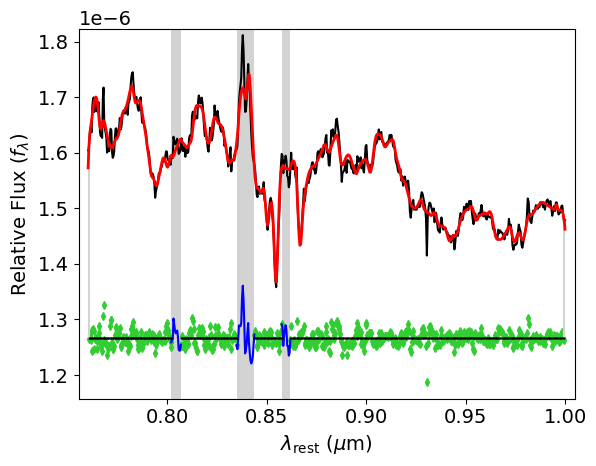

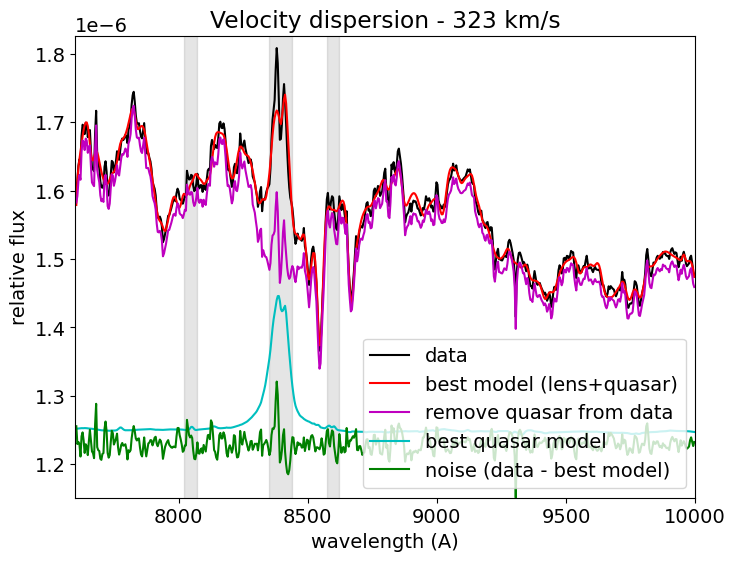

Formal errors:
     dV    dsigma   dh3      dh4
      11      14
Elapsed time in pPXF: 479.21 s

###########################################################
bin number 41
velscale is  138.229913538939
galaxy (595,)
lam (595,)
global_etmp (636,)
glob lam (636,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]
 Best Fit:       Vel     sigma
 comp.  0:       211       321
chi2/DOF: 3.323e-12; DOF: 537; degree = 30; mdegree = 10
method = capfit; Jac calls: 6; Func calls: 86; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
     0.148  1.15e-08
Formal errors:
     dV    dsigma   dh3      dh4
     6.7     8.2
Elapsed time in pPXF: 480.56 s

###########################################################
bin number 42
velscale is  138.229913538939
galaxy (595,)
lam (595,)
global_etmp (636,)
glob lam (636,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]
 Best Fit:       Vel     sigma
 comp.  0:       225       284
chi2/DOF: 4.840e-11; D

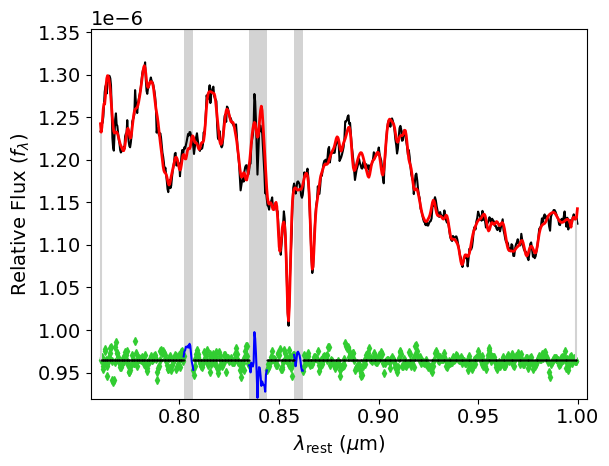

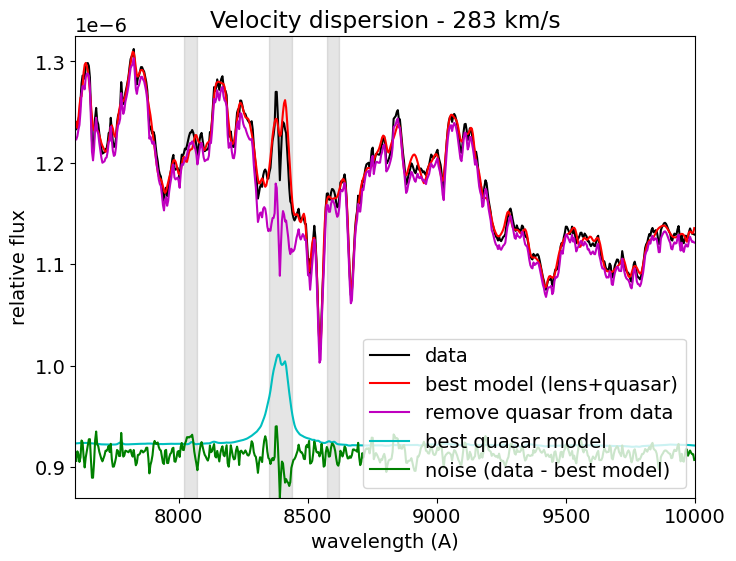

Formal errors:
     dV    dsigma   dh3      dh4
     7.5       9
Elapsed time in pPXF: 493.95 s

###########################################################
bin number 51
velscale is  138.229913538939
galaxy (595,)
lam (595,)
global_etmp (636,)
glob lam (636,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]
 Best Fit:       Vel     sigma
 comp.  0:       196       299
chi2/DOF: 2.000e-11; DOF: 537; degree = 30; mdegree = 10
method = capfit; Jac calls: 12; Func calls: 169; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
      0.13   2.6e-08
Formal errors:
     dV    dsigma   dh3      dh4
      17      20
Elapsed time in pPXF: 495.60 s

###########################################################
bin number 52
velscale is  138.229913538939
galaxy (595,)
lam (595,)
global_etmp (636,)
glob lam (636,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]
 Best Fit:       Vel     sigma
 comp.  0:       206       307
chi2/DOF: 8.708e-12;

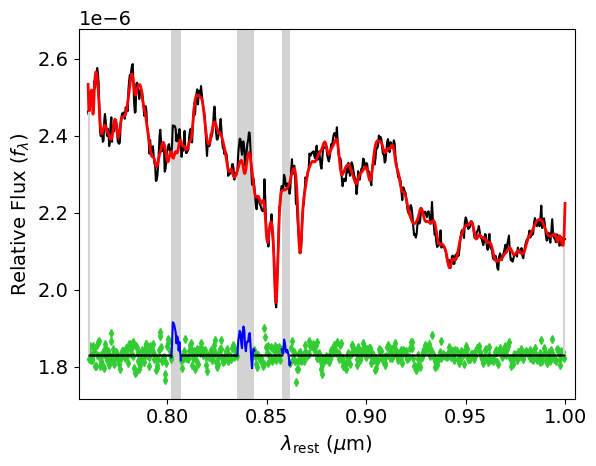

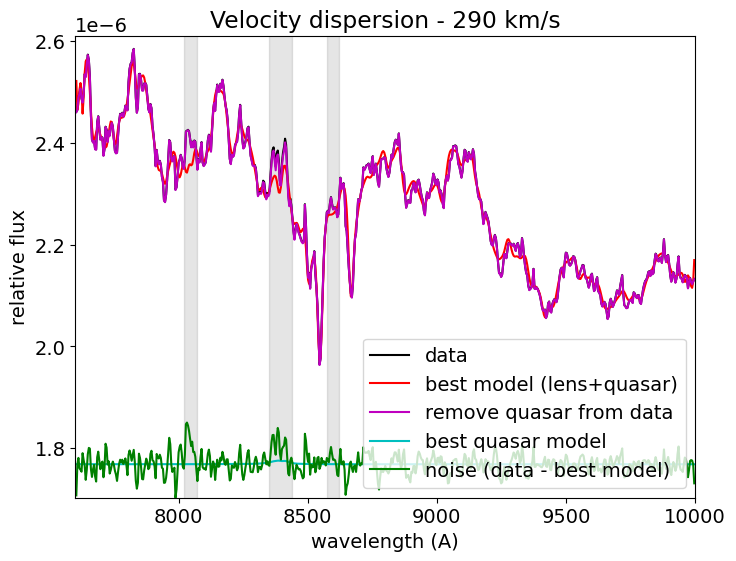

Formal errors:
     dV    dsigma   dh3      dh4
      10      13
Elapsed time in pPXF: 508.95 s

###########################################################
bin number 61
velscale is  138.229913538939
galaxy (595,)
lam (595,)
global_etmp (636,)
glob lam (636,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]
 Best Fit:       Vel     sigma
 comp.  0:       193       310
chi2/DOF: 3.625e-11; DOF: 537; degree = 30; mdegree = 10
method = capfit; Jac calls: 12; Func calls: 165; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
     0.129  9.07e-09
Formal errors:
     dV    dsigma   dh3      dh4
      22      27
Elapsed time in pPXF: 510.59 s

###########################################################
bin number 62
velscale is  138.229913538939
galaxy (595,)
lam (595,)
global_etmp (636,)
glob lam (636,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]
 Best Fit:       Vel     sigma
 comp.  0:       188       280
chi2/DOF: 1.519e-11;

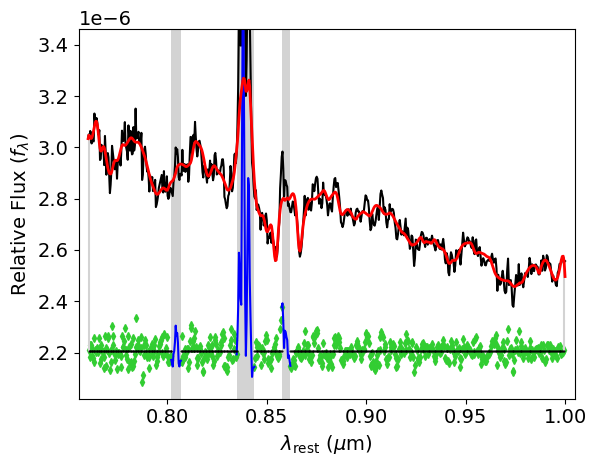

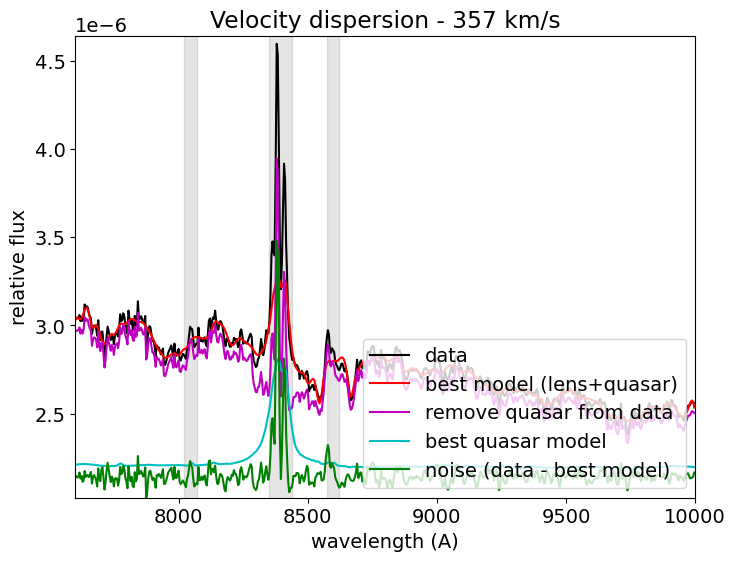

Formal errors:
     dV    dsigma   dh3      dh4
      28      36
Elapsed time in pPXF: 524.26 s

###########################################################
bin number 71
velscale is  138.229913538939
galaxy (595,)
lam (595,)
global_etmp (636,)
glob lam (636,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]
 Best Fit:       Vel     sigma
 comp.  0:       185       450
chi2/DOF: 5.045e-11; DOF: 537; degree = 30; mdegree = 10
method = capfit; Jac calls: 8; Func calls: 115; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
     0.135  5.49e-08


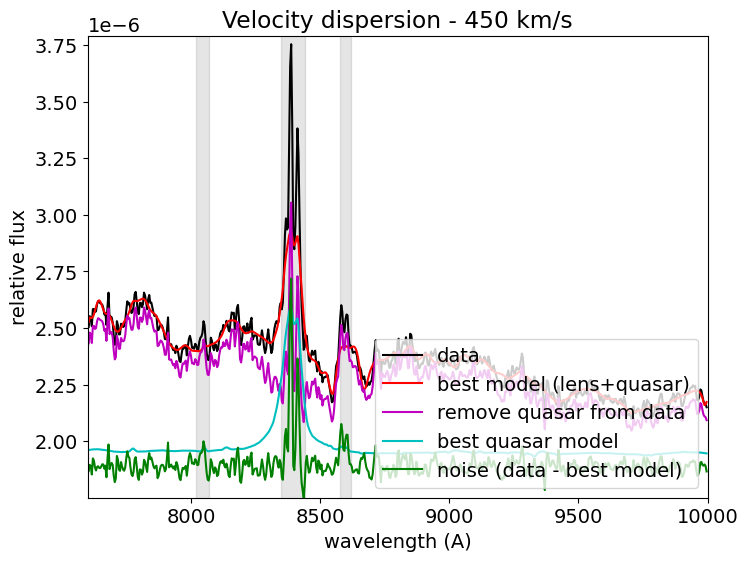

Formal errors:
     dV    dsigma   dh3      dh4
      36      44
Elapsed time in pPXF: 527.00 s

###########################################################
bin number 72
velscale is  138.229913538939
galaxy (595,)
lam (595,)
global_etmp (636,)
glob lam (636,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]
 Best Fit:       Vel     sigma
 comp.  0:       157       328
chi2/DOF: 5.272e-11; DOF: 537; degree = 30; mdegree = 10
method = capfit; Jac calls: 7; Func calls: 103; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/2
Templates weights:
    0.0908   7.6e-08
Formal errors:
     dV    dsigma   dh3      dh4
      32      38
Elapsed time in pPXF: 528.42 s

###########################################################
bin number 73
velscale is  138.229913538939
galaxy (595,)
lam (595,)
global_etmp (636,)
glob lam (636,)
masking quasar between  [[8020 8350 8575]
 [8070 8440 8620]]
 Best Fit:       Vel     sigma
 comp.  0:       194       347
chi2/DOF: 2.997e-11; 

In [505]:
voronoi_binning_data = fits.getdata(data_dir +'voronoi_binning_' + obj_name + '_data.fits')
measurements = np.zeros(shape=(0,5))
N = voronoi_binning_data.shape[0]
for i in range(N):
    print()
    print('###########################################################')
    print('bin number', i)
    if i % 10 == 0: # print every 10
        plot=True
    else:
        plot=False
    
    bin_spectrum = voronoi_binning_data[i]
    galaxy, logLam1, velscale_ = ppxf_util.log_rebin(lamRange1, bin_spectrum)
    lam = np.exp(logLam1.copy())#lam_full.copy()#
    print('velscale is ', velscale)
    
    galaxy = galaxy[lam>wave_min] 
    background_source = background_source_full.copy()[lam>wave_min]
    lam = lam[lam>wave_min]
    galaxy = galaxy[lam<wave_max]
    background_source = background_source[lam<wave_max]
    lam = lam[lam<wave_max]
    
    galaxy /= lam**2
    #background_source /= lam**2
    
    print('galaxy',galaxy.shape)
    print('lam',lam.shape)
    print('global_etmp',global_temp.shape)
    print('glob lam',global_temp_lam.shape)
    
    noise = np.full_like(galaxy, 0.0047)
    
    lam_range_global_temp = np.array([global_temp_lam.min(), global_temp_lam.max()])
    # after de-redshift, the initial redshift is zero.
    goodPixels = ppxf_util.determine_goodpixels(np.log(lam), lam_range_global_temp, 0)
    #print(goodPixels)

    ind_min = find_nearest(lam, wave_min)
    ind_max = find_nearest(lam, wave_max)

    mask=goodPixels[goodPixels<ind_max]
    mask = mask[mask>ind_min]
    if mask_quasar is not None:
        print('masking quasar between ', mask_quasar)
        for i in range(mask_quasar.shape[1]):
            # mask_quasar should be a list of two wavelengths
            quasar_ind_min = find_nearest(lam, mask_quasar[0,i])
            quasar_ind_max = find_nearest(lam, mask_quasar[1,i])
            boolen = ~((quasar_ind_min < mask) & (mask < quasar_ind_max))  # mask quasar
            mask = mask[boolen]

    pp = ppxf(global_temp, galaxy, noise, velscale, start, plot=plot,
          moments=2, goodpixels=mask,
          degree=30,#degree, m
          mdegree=10,#mdegree,
          velscale_ratio=velscale_ratio,
          sky=background_source, 
         lam=lam,
          lam_temp=global_temp_lam,
         bounds=bounds
             )
    #plt.xlim(wave_min*1e-4, wave_max*1e-4)
    plt.pause(1)
    
    if (plot==True) or (pp.sol[1]==450):
        best_sky = background_source * pp.weights[-1]

        gal_lin = pp.galaxy#spectrum_perpixel

        log_axis_sky = lam
        lin_axis_sky = np.linspace(wave_min, wave_max, gal_lin.size)

        sky_lin = de_log_rebin(log_axis_sky, best_sky, lin_axis_sky)
        best_lin = de_log_rebin(log_axis_sky, pp.bestfit, lin_axis_sky)
        gal_lin = de_log_rebin(log_axis_sky, gal_lin, lin_axis_sky)

        more_noise = gal_lin - best_lin

        plt.figure(figsize=(8,6))
        plt.plot(lin_axis_sky, gal_lin, 'k-', label='data')
        plt.plot(lin_axis_sky, best_lin, 'r-', label='best model ('
                                                     'lens+quasar)')
        plt.plot(lin_axis_sky, gal_lin - sky_lin, 'm-',
                 label='remove quasar from data')
        plt.plot(lin_axis_sky, sky_lin + np.full_like(sky_lin, 0.9*np.nanmin(gal_lin)), 'c-',label='best quasar model')
        plt.plot(lin_axis_sky, more_noise + np.full_like(sky_lin, 0.9*np.nanmin(gal_lin)), 'g-',
         label='noise (data - best model)')
        if mask_quasar is not None:
            for i in range(mask_quasar.shape[1]):
                plt.fill_between(mask_quasar[:,i], [0,0], [1,1], color='k', alpha=0.1)
        plt.legend(loc='lower right')
        plt.ylim(np.nanmin(more_noise + np.full_like(sky_lin, 0.9*np.nanmin(gal_lin))), np.nanmax(gal_lin)*1.01)
        plt.xlim(lin_axis_sky.min(), lin_axis_sky.max())
        plt.xlabel('wavelength (A)')
        plt.ylabel('relative flux')
        plt.title(f'Velocity dispersion - {int(pp.sol[1])} km/s')
        plt.show()
        plt.pause(1)
        
    
    print("Formal errors:")
    print("     dV    dsigma   dh3      dh4")
    print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

    print('Elapsed time in pPXF: %.2f s' % (clock() - t))

    measurements = np.vstack((measurements, np.hstack( (pp.sol[:2],
                                               (pp.error*np.sqrt(pp.chi2))[:2],
                                                          pp.chi2) 
                                                          )
                             )
                            )

In [506]:
# Vel, sigma, dv, dsigma
output=np.loadtxt(data_dir +'voronoi_2d_binning_' + obj_name + '_output.txt')

VD_array    =np.zeros(output.shape[0])
noise_array =np.zeros(output.shape[0])
V_array     =np.zeros(output.shape[0])
dv_array    =np.zeros(output.shape[0])


for i in range(output.shape[0]):
    num=int(output.T[2][i])
    results = measurements[num][1]
    sigma = measurements[num][3]
    v = measurements[num][0]
    dv = measurements[num][2]

    VD_array[i]=results
    noise_array[i]=sigma
    V_array[i]=v
    dv_array[i]=dv


final=np.vstack((output.T, VD_array, noise_array, V_array, dv_array))

dim = 10*2+1

VD_2d=np.zeros((dim, dim))
VD_2d[:]=np.nan
for i in range(final.shape[1]):
    VD_2d[int(final[1][i])][int(final[0][i])]=final[3][i]

dVD_2d=np.zeros((dim, dim))
dVD_2d[:]=np.nan
for i in range(final.shape[1]):
    dVD_2d[int(final[1][i])][int(final[0][i])]=final[4][i]


V_2d=np.zeros((dim, dim))
V_2d[:]=np.nan
for i in range(final.shape[1]):
    V_2d[int(final[1][i])][int(final[0][i])]=final[5][i]

dV_2d=np.zeros((dim, dim))
dV_2d[:]=np.nan
for i in range(final.shape[1]):
    dV_2d[int(final[1][i])][int(final[0][i])]=final[6][i]


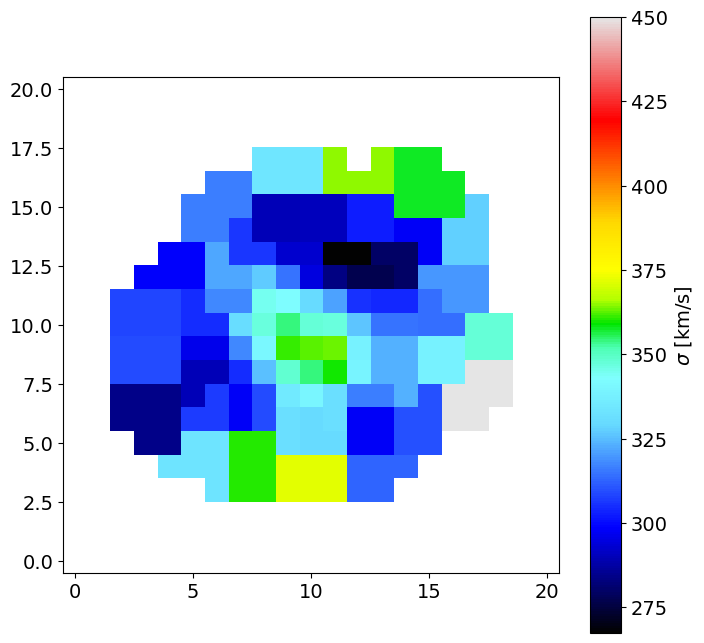

<Figure size 640x480 with 0 Axes>

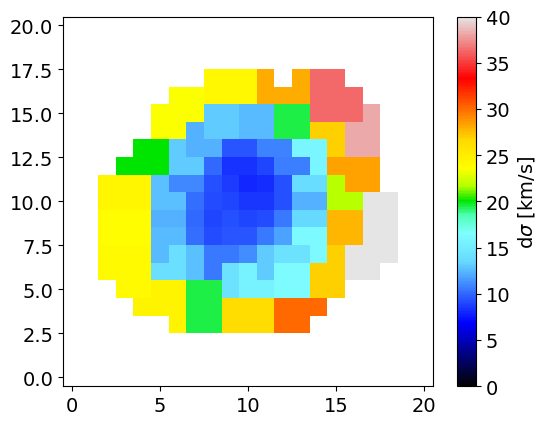

<Figure size 640x480 with 0 Axes>

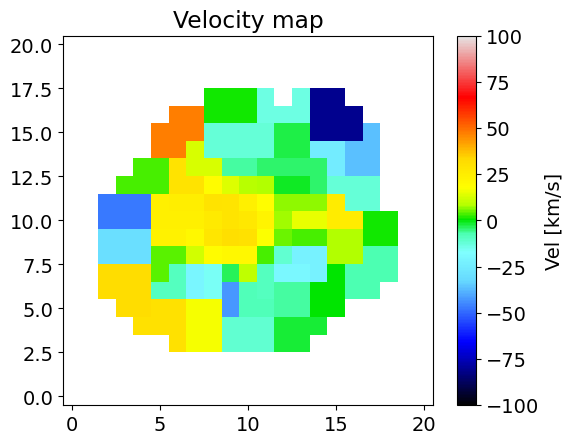

<Figure size 640x480 with 0 Axes>

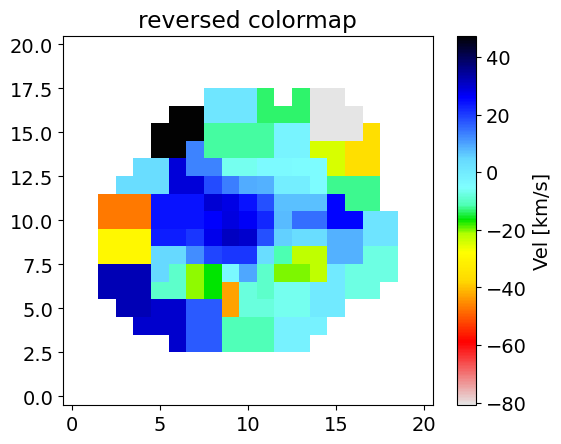

Done. Run systematics now.
###########################################################


<Figure size 640x480 with 0 Axes>

In [507]:
target_dir = data_dir
# plot each
plt.figure(figsize=(8,8))
plt.imshow(VD_2d,origin='lower',cmap='sauron')
cbar1 = plt.colorbar()
cbar1.set_label(r'$\sigma$ [km/s]')
plt.savefig(target_dir + obj_name + '_VD.png')
plt.pause(1)
plt.clf()

plt.figure()
plt.imshow(dVD_2d, origin='lower', cmap='sauron',vmin=0, vmax=40)
cbar2 = plt.colorbar()
cbar2.set_label(r'd$\sigma$ [km/s]')
plt.savefig(target_dir + obj_name + '_dVD.png')
plt.pause(1)
plt.clf()

# mean is bulk velocity, maybe?
mean = np.nanmedian(V_2d)
#
plt.figure()
plt.imshow(V_2d-mean,origin='lower',cmap='sauron',vmin=-100, vmax=100)
cbar3 = plt.colorbar()
cbar3.set_label(r'Vel [km/s]')
plt.title("Velocity map")
plt.savefig(target_dir + obj_name + '_V.png')
plt.pause(1)
plt.clf()

plt.figure()
plt.imshow(V_2d-mean,origin='lower',cmap='sauron_r')
cbar4 = plt.colorbar()
cbar4.set_label(r'Vel [km/s]')
plt.title("reversed colormap")
plt.pause(1)
plt.clf()

print('Done. Run systematics now.')
print('###########################################################')

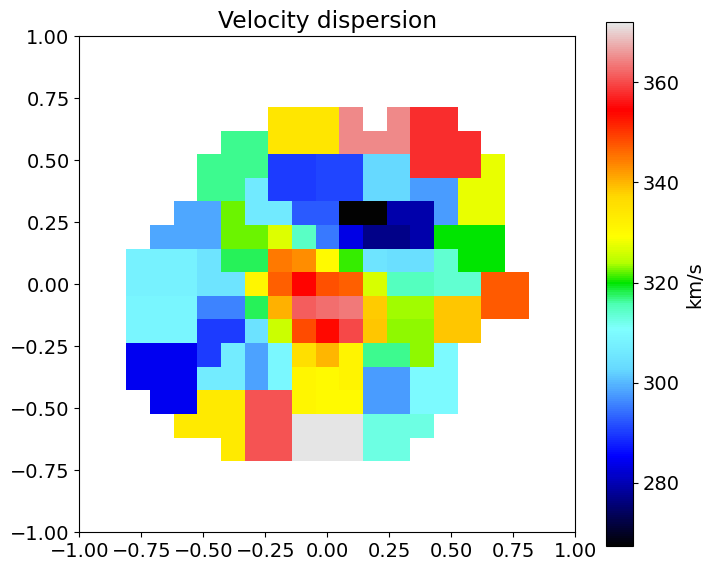

In [508]:
VD_goodbins = (dVD_2d < 100) & (VD_2d<450) & (VD_2d>0) 
VD_2d_good = VD_2d.copy()
VD_2d_good[~VD_goodbins] = 'nan'#VD_2d_good[~VD_goodbins]*0.8#'nan'

plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(8,8))
p=plt.imshow(VD_2d_good, origin='lower', extent=[-1.0, 1.0, -1.0, 1.0], cmap='sauron')
plt.title('Velocity dispersion')
plt.colorbar(p, label='km/s', shrink=0.85)


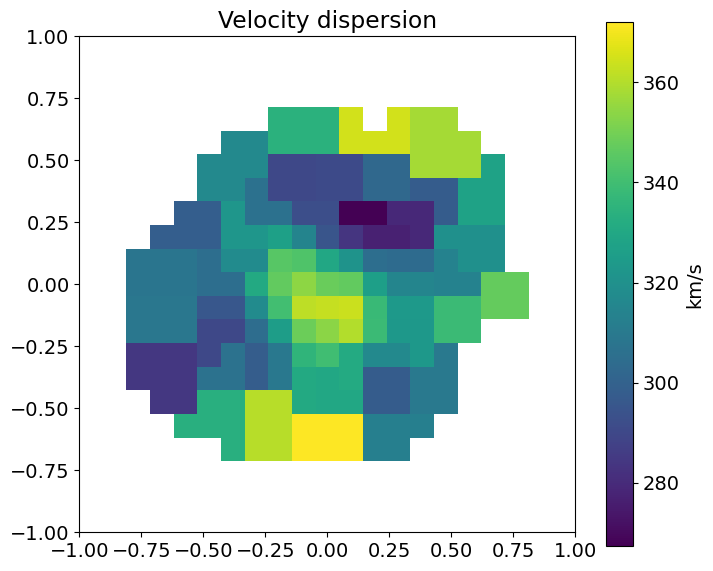

In [512]:
VD_goodbins = (dVD_2d < 80) & (VD_2d<450) & (VD_2d>0) 
VD_2d_good = VD_2d.copy()
VD_2d_good[~VD_goodbins] = 'nan'#VD_2d_good[~VD_goodbins]*0.8#'nan'

plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(8,8))
p=plt.imshow(VD_2d_good, origin='lower', extent=[-1.0, 1.0, -1.0, 1.0])#, cmap='sauron')
plt.title('Velocity dispersion')
plt.colorbar(p, label='km/s', shrink=0.85)
